# Library

In [1]:
import numpy as np, os
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

# Data Load

In [2]:
# LSH
all_df = pd.read_csv('df_all_best.csv')
all_df = all_df.sort_values(by='diff',ascending=False)

df_d1d5 = pd.read_csv('df_d1d5_best.csv')
df_d1d5 = df_d1d5.sort_values(by='diff',ascending=False)

df_d6d10 = pd.read_csv('df_d6d10_best.csv')
df_d6d10 = df_d6d10.sort_values(by='diff',ascending=False)

# 전체 공통 부분 (1~4번 과정)
- 1 ~ 4번은 전체 공통과정, 6 ~ 8번은 PRE, PRO, LAB별로 인자 다르게 해서 함수 적용
- 5번은 all reversed / d1d5 / d6d10 마다 셀 실행

In [ ]:
# 1) DATA 
import random    
# ---------------------
seed_num = 42
# ---------------------
random.seed(seed_num)

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

# 3) y label이 0, 1인 환자의 index 각각 구하기 
y_test_0_index = []
y_test_1_index = []

for i,j in enumerate(y_test):
    if j == 0:
        y_test_0_index.append(i)
    else:
        y_test_1_index.append(i)
        
# 4) No Change - label 0,1에 대한 평균 (baseline)
pred = lstm2.predict(X_test)
pred_label_0 = np.mean(pred[y_test_0_index])
pred_label_1 = np.mean(pred[y_test_1_index])

# change 함수 (6~8번 과정)

In [37]:
def change(PPL_list, before, after):
    
    # 6) PPL_top 10개에 대한 ITEMID의 index list 생성 
    PPL_top10 = PPL_list[:10]
    item_list = total_data['ITEMID'].sort_values().unique()

    PPL_index = []
    for i in PPL_top10:
        a = list(item_list).index(i)
        PPL_index.append(a)
    features = PPL_index

    # 7) ITEMID별 Changing values to 1
    results = []
    results.append({'feature':'baseline',
                    'pred_label_0':pred_label_0,
                    'pred_label_1':pred_label_1})

    for i, k in tqdm(enumerate(features)):
        save_col = X_test[:,:,k].copy()
        X_test[:,:,k] = np.where(X_test[:,:,k]==int(f'{before}'), int(f'{after}'), X_test[:,:,k])

        preds = lstm2.predict(X_test)
        results.append({'feature':PPL_top10[i],
                        'pred_label_0':np.mean(preds[y_test_0_index]),
                        'pred_label_1':np.mean(preds[y_test_1_index])})
        X_test[:,:,k] = save_col
    
    # 8) PPL_top10에 대한 label별 평균 preds 그래프 
    df = pd.DataFrame(results)
    df = df.melt(id_vars='feature', value_vars=['pred_label_0', 'pred_label_1'])

    ax = plt.figure(figsize = (13,12),dpi=150)

    for i,j in enumerate(PPL_top10):
        _ = plt.subplot(4,3,1+i)
        _ = plt.ylim(0,1)
        _ = plt.title(j)
        df1 = df[df['feature'].isin(['baseline',j])]
        _ = ax.legend(loc = 'upper left', fontsize=12)
        _ = ax = sns.barplot(data = df1, x = 'variable', y = 'value', hue='feature')

    plt.tight_layout()

# All reversed - 그래프
- All reversed 방법으로 뽑은 top10 item에 대해 changing values 한 후 사망자, 생존자별 평균예측값 비교

In [77]:
# 5) All reversed / d1d5 / d6d10에 따라 다르게 실행 

total_data = pd.read_csv('total_data_7727.csv')

# ---------------------------------------
all_feature = all_df['feature'].tolist()
# ---------------------------------------

# LAB, PRE, PRO의 item_list 생성 
LAB_item = total_data[total_data['TYPE']=='LAB']['ITEMID'].unique()
PRE_item = total_data[total_data['TYPE']=='PRE']['ITEMID'].unique()
PRO_item = total_data[total_data['TYPE']=='PRO']['ITEMID'].unique()

LAB_list = []
PRE_list = []
PRO_list = []

# ---------------------------------------
for i in all_feature:
# ---------------------------------------
    if i in LAB_item:
        LAB_list.append(i)
    elif i in PRE_item:
        PRE_list.append(i)
    else:
        PRO_list.append(i)

## PRE  - top10 
- baseline보다 평균예측값이 작은 경우, 생존자(0) - 생존예측률 증가 / 사망자(1) - 사망예측률 감소
    - 생존에 관련있는 feature
- baseline보다 평균예측값이 큰 경우, 생존자(0) - 생존예측률 감소 / 사망자(1) - 사망예측률 증가
    - 사망에 관련있는 feature

10it [00:04,  2.30it/s]
No handles with labels found to put in legend.


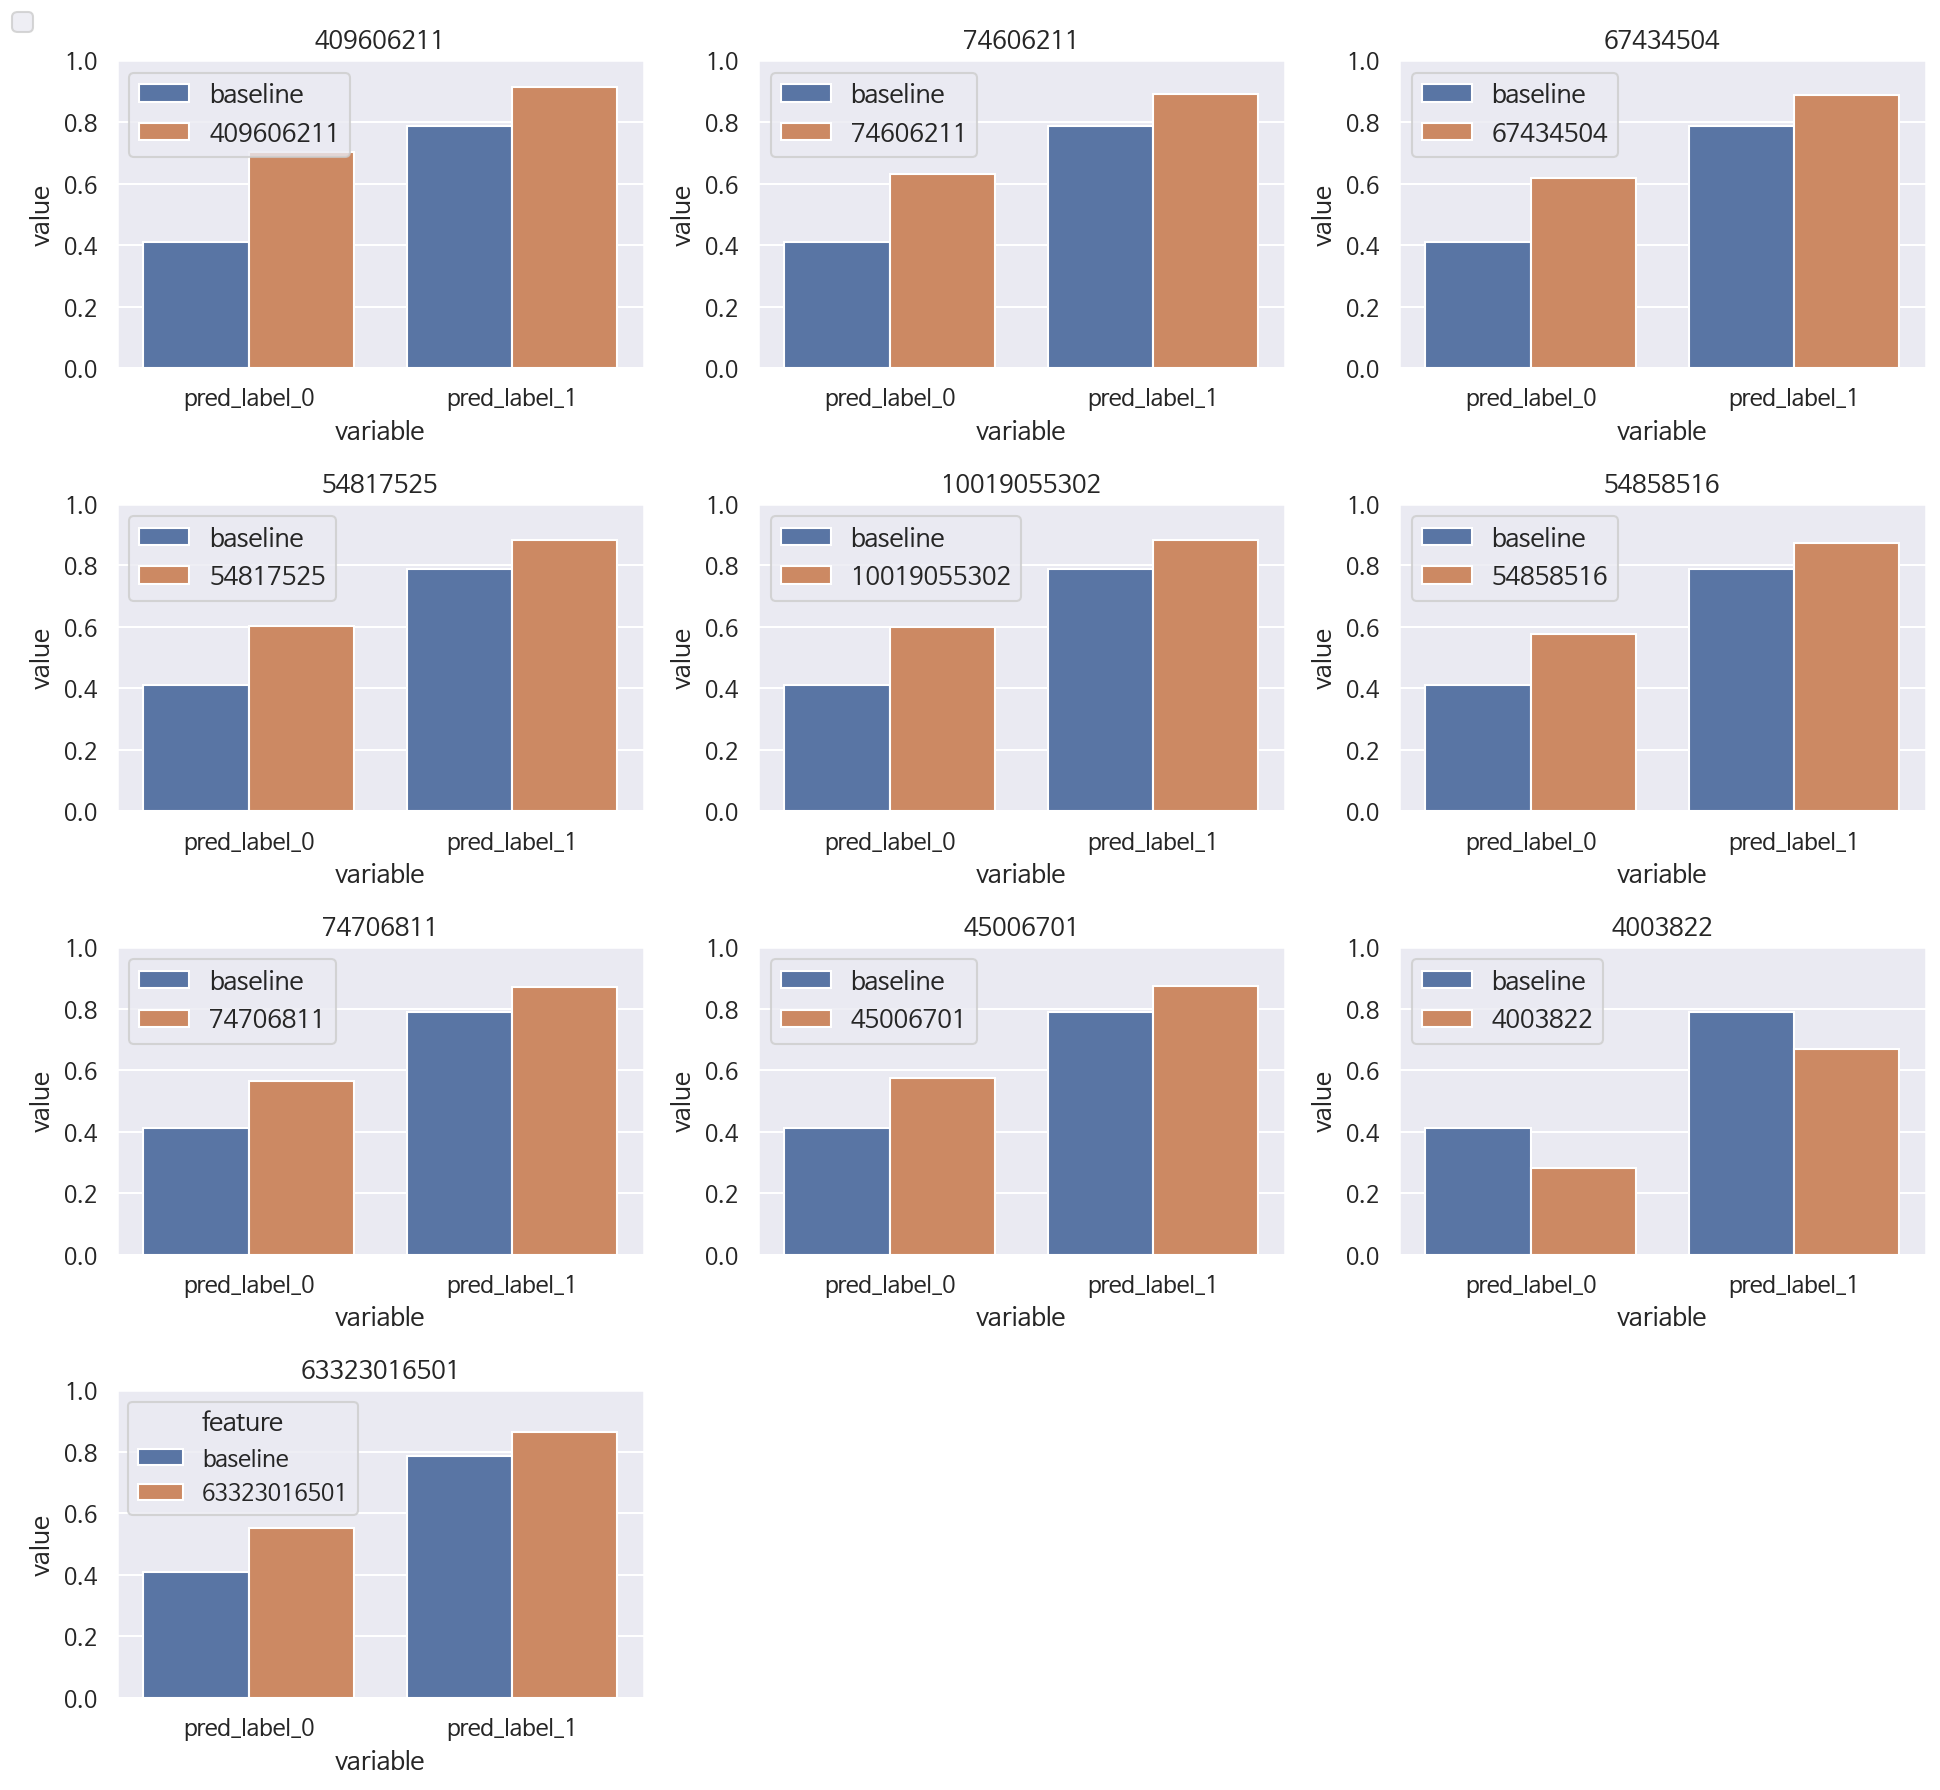

In [78]:
change(PRE_list,0,1)

10it [00:04,  2.32it/s]
No handles with labels found to put in legend.


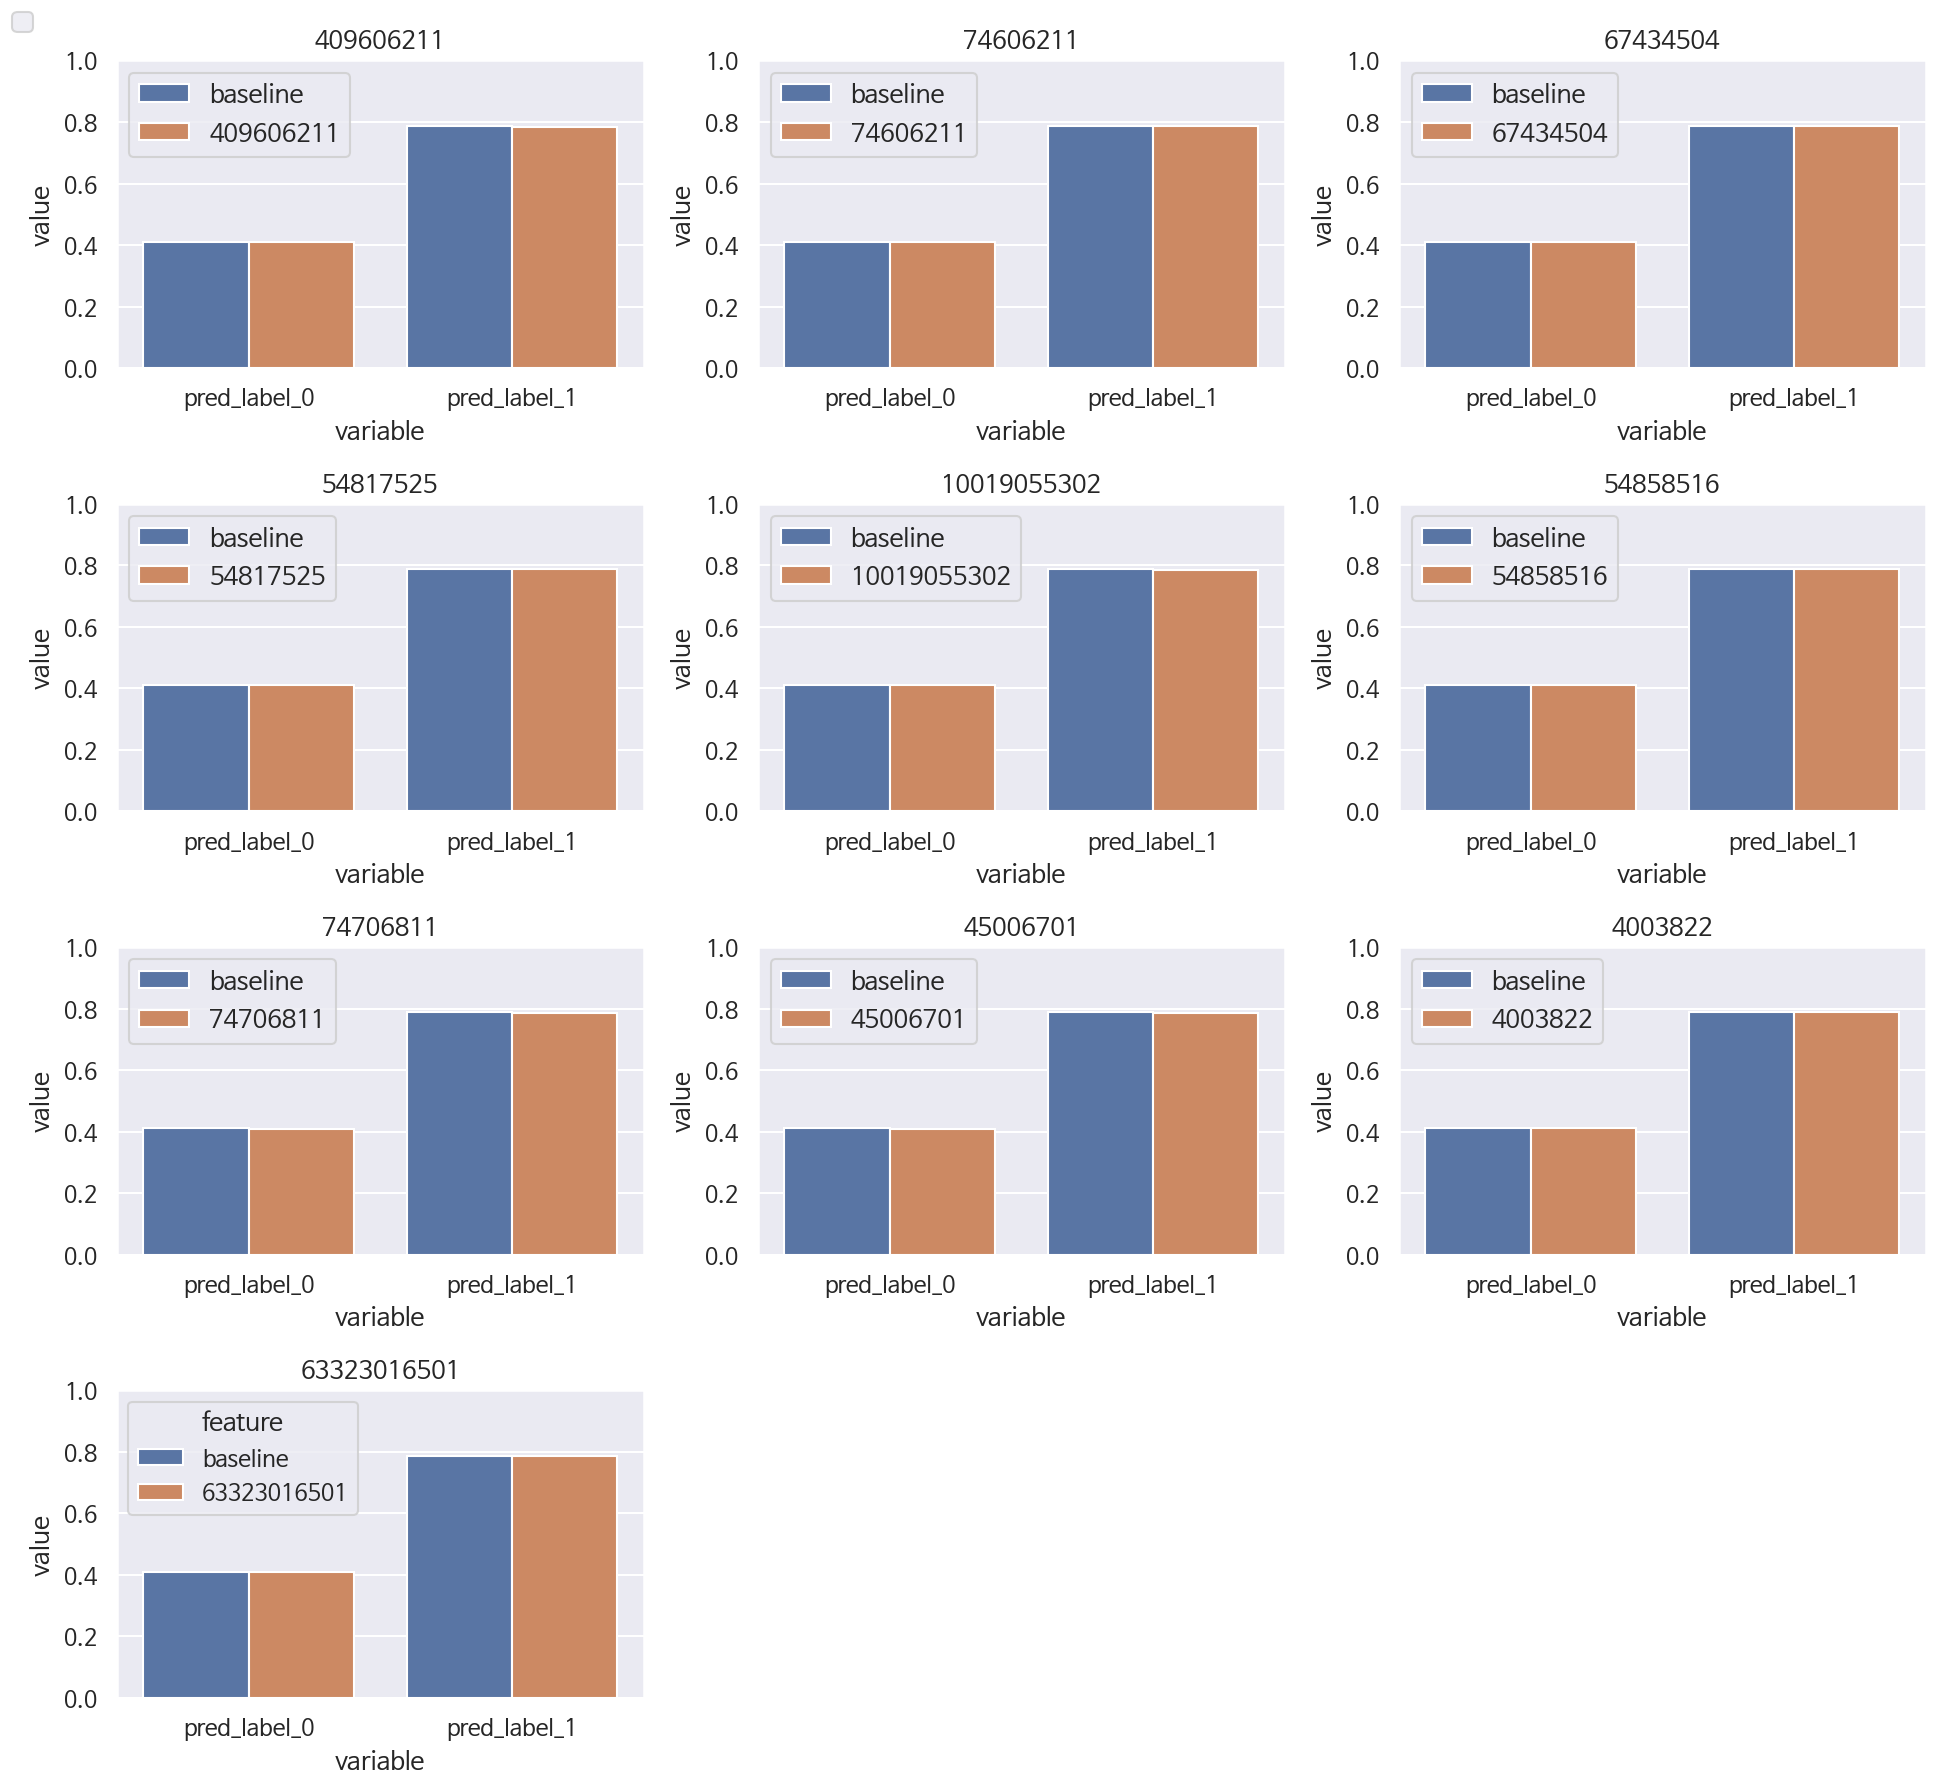

In [79]:
change(PRE_list,1,0)

## PRO - top10

10it [00:04,  2.36it/s]
No handles with labels found to put in legend.


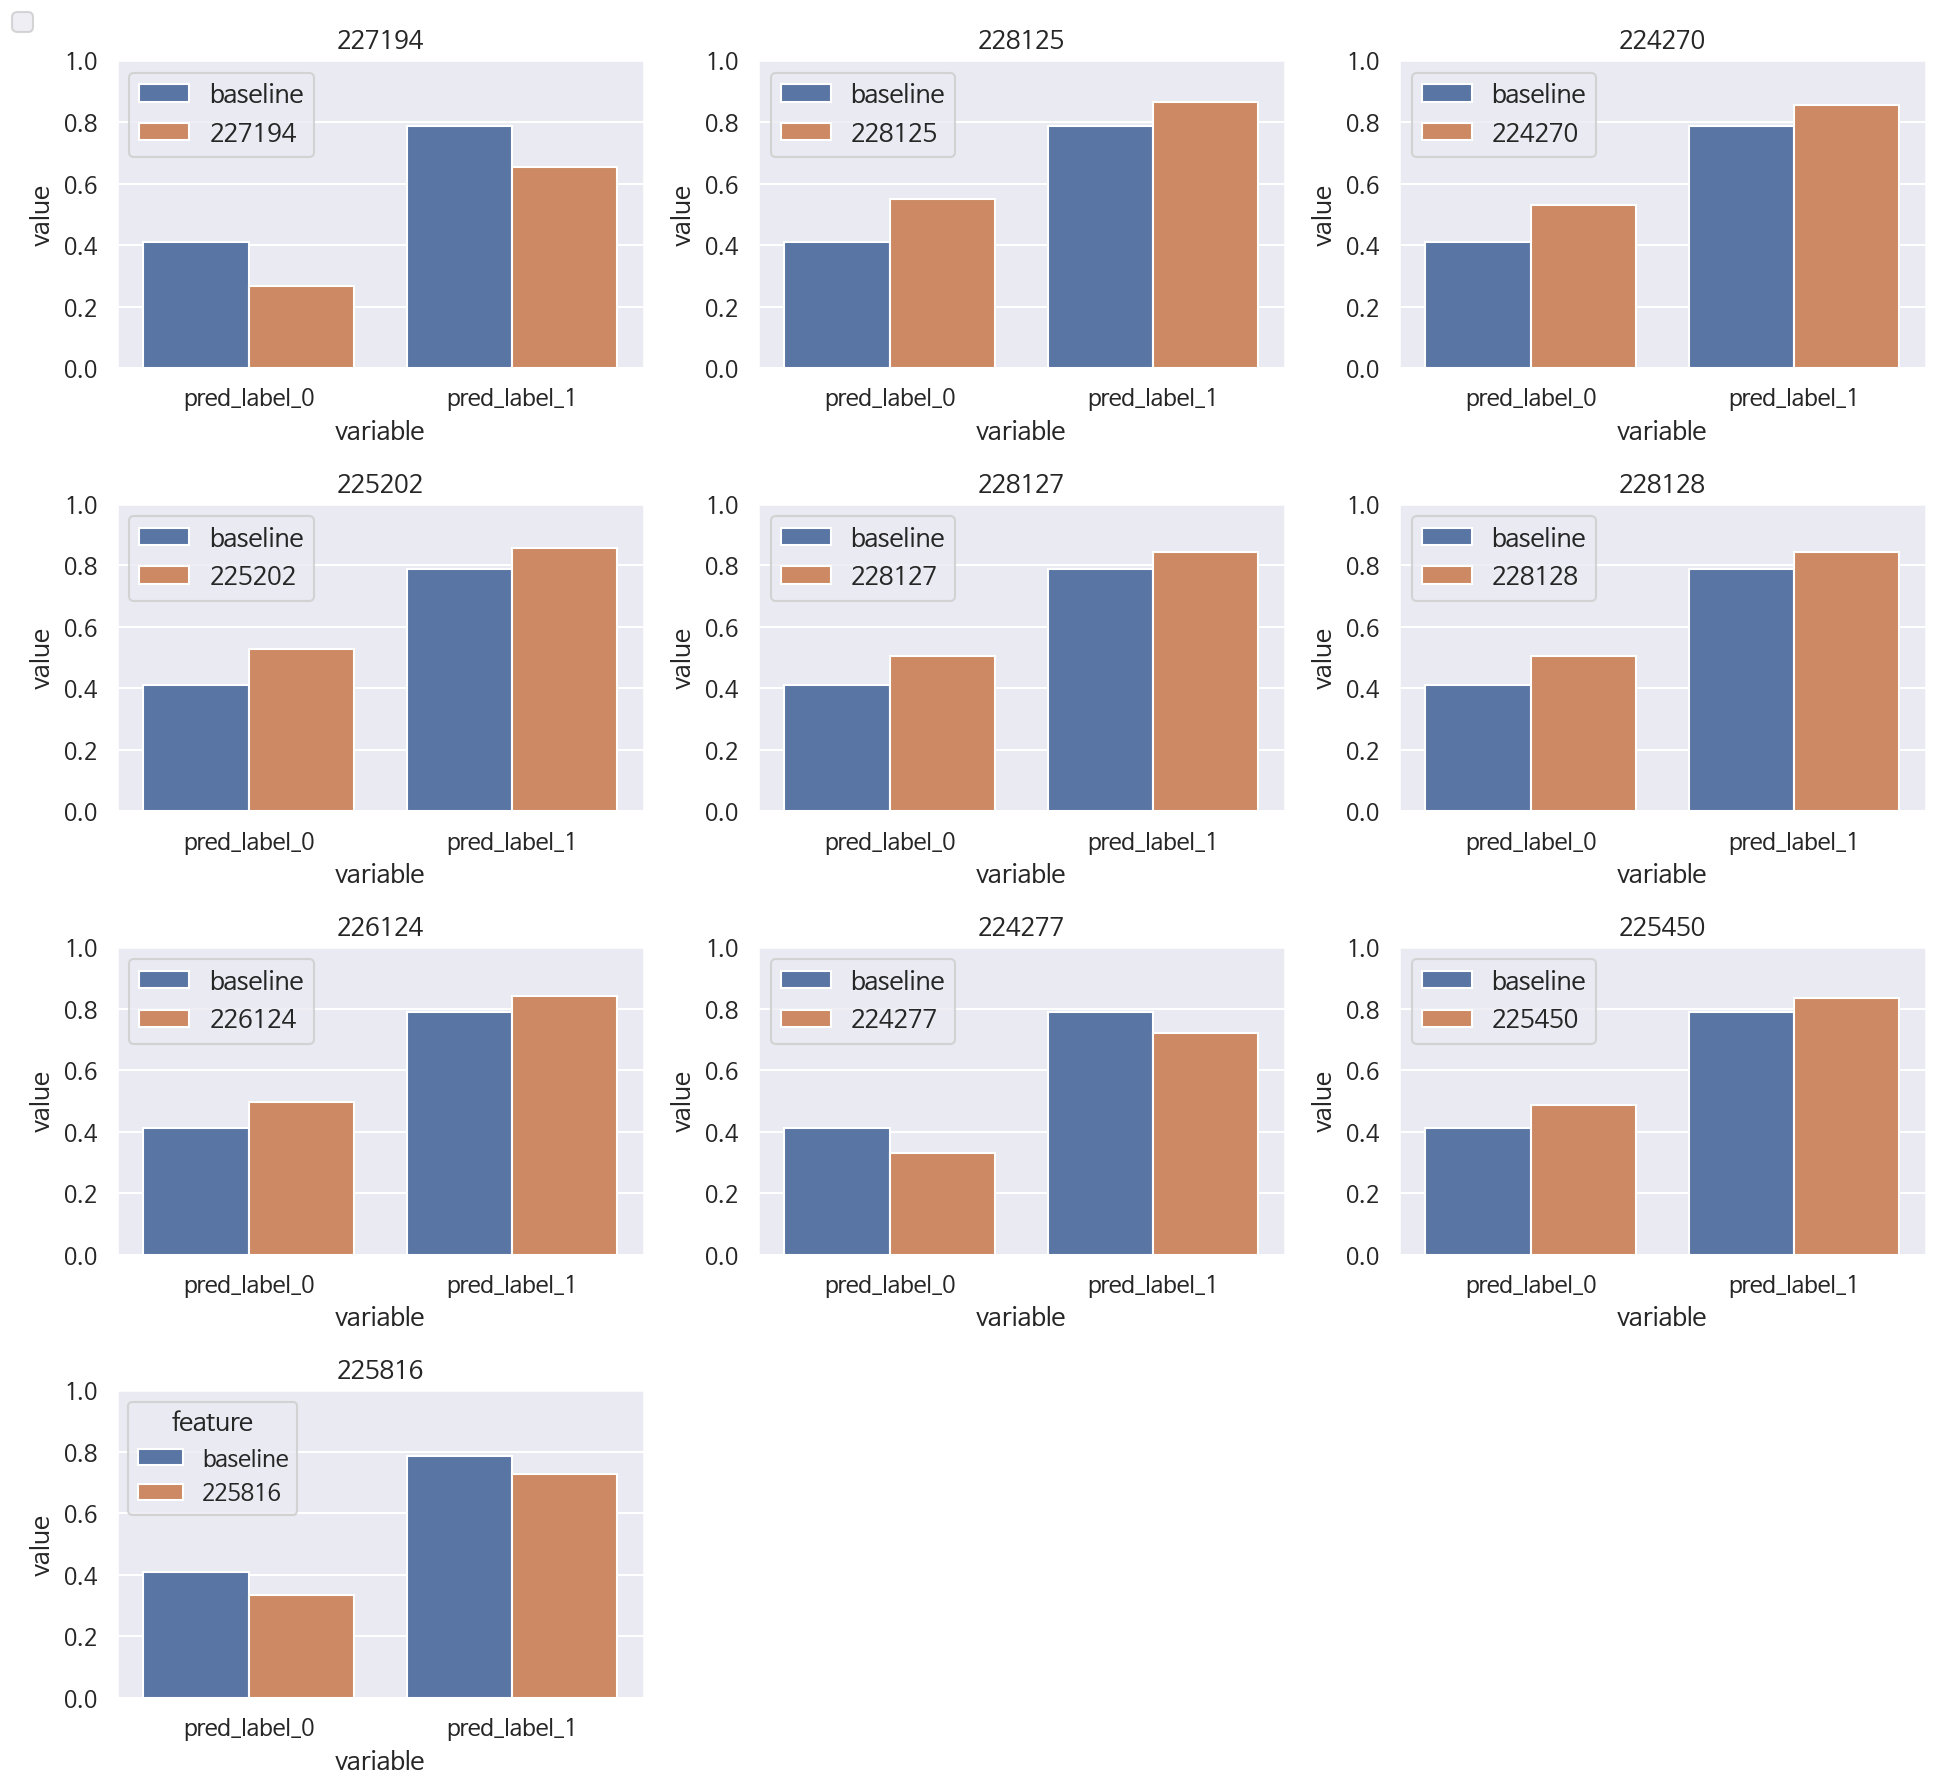

In [80]:
change(PRO_list,0,1)

10it [00:04,  2.33it/s]
No handles with labels found to put in legend.


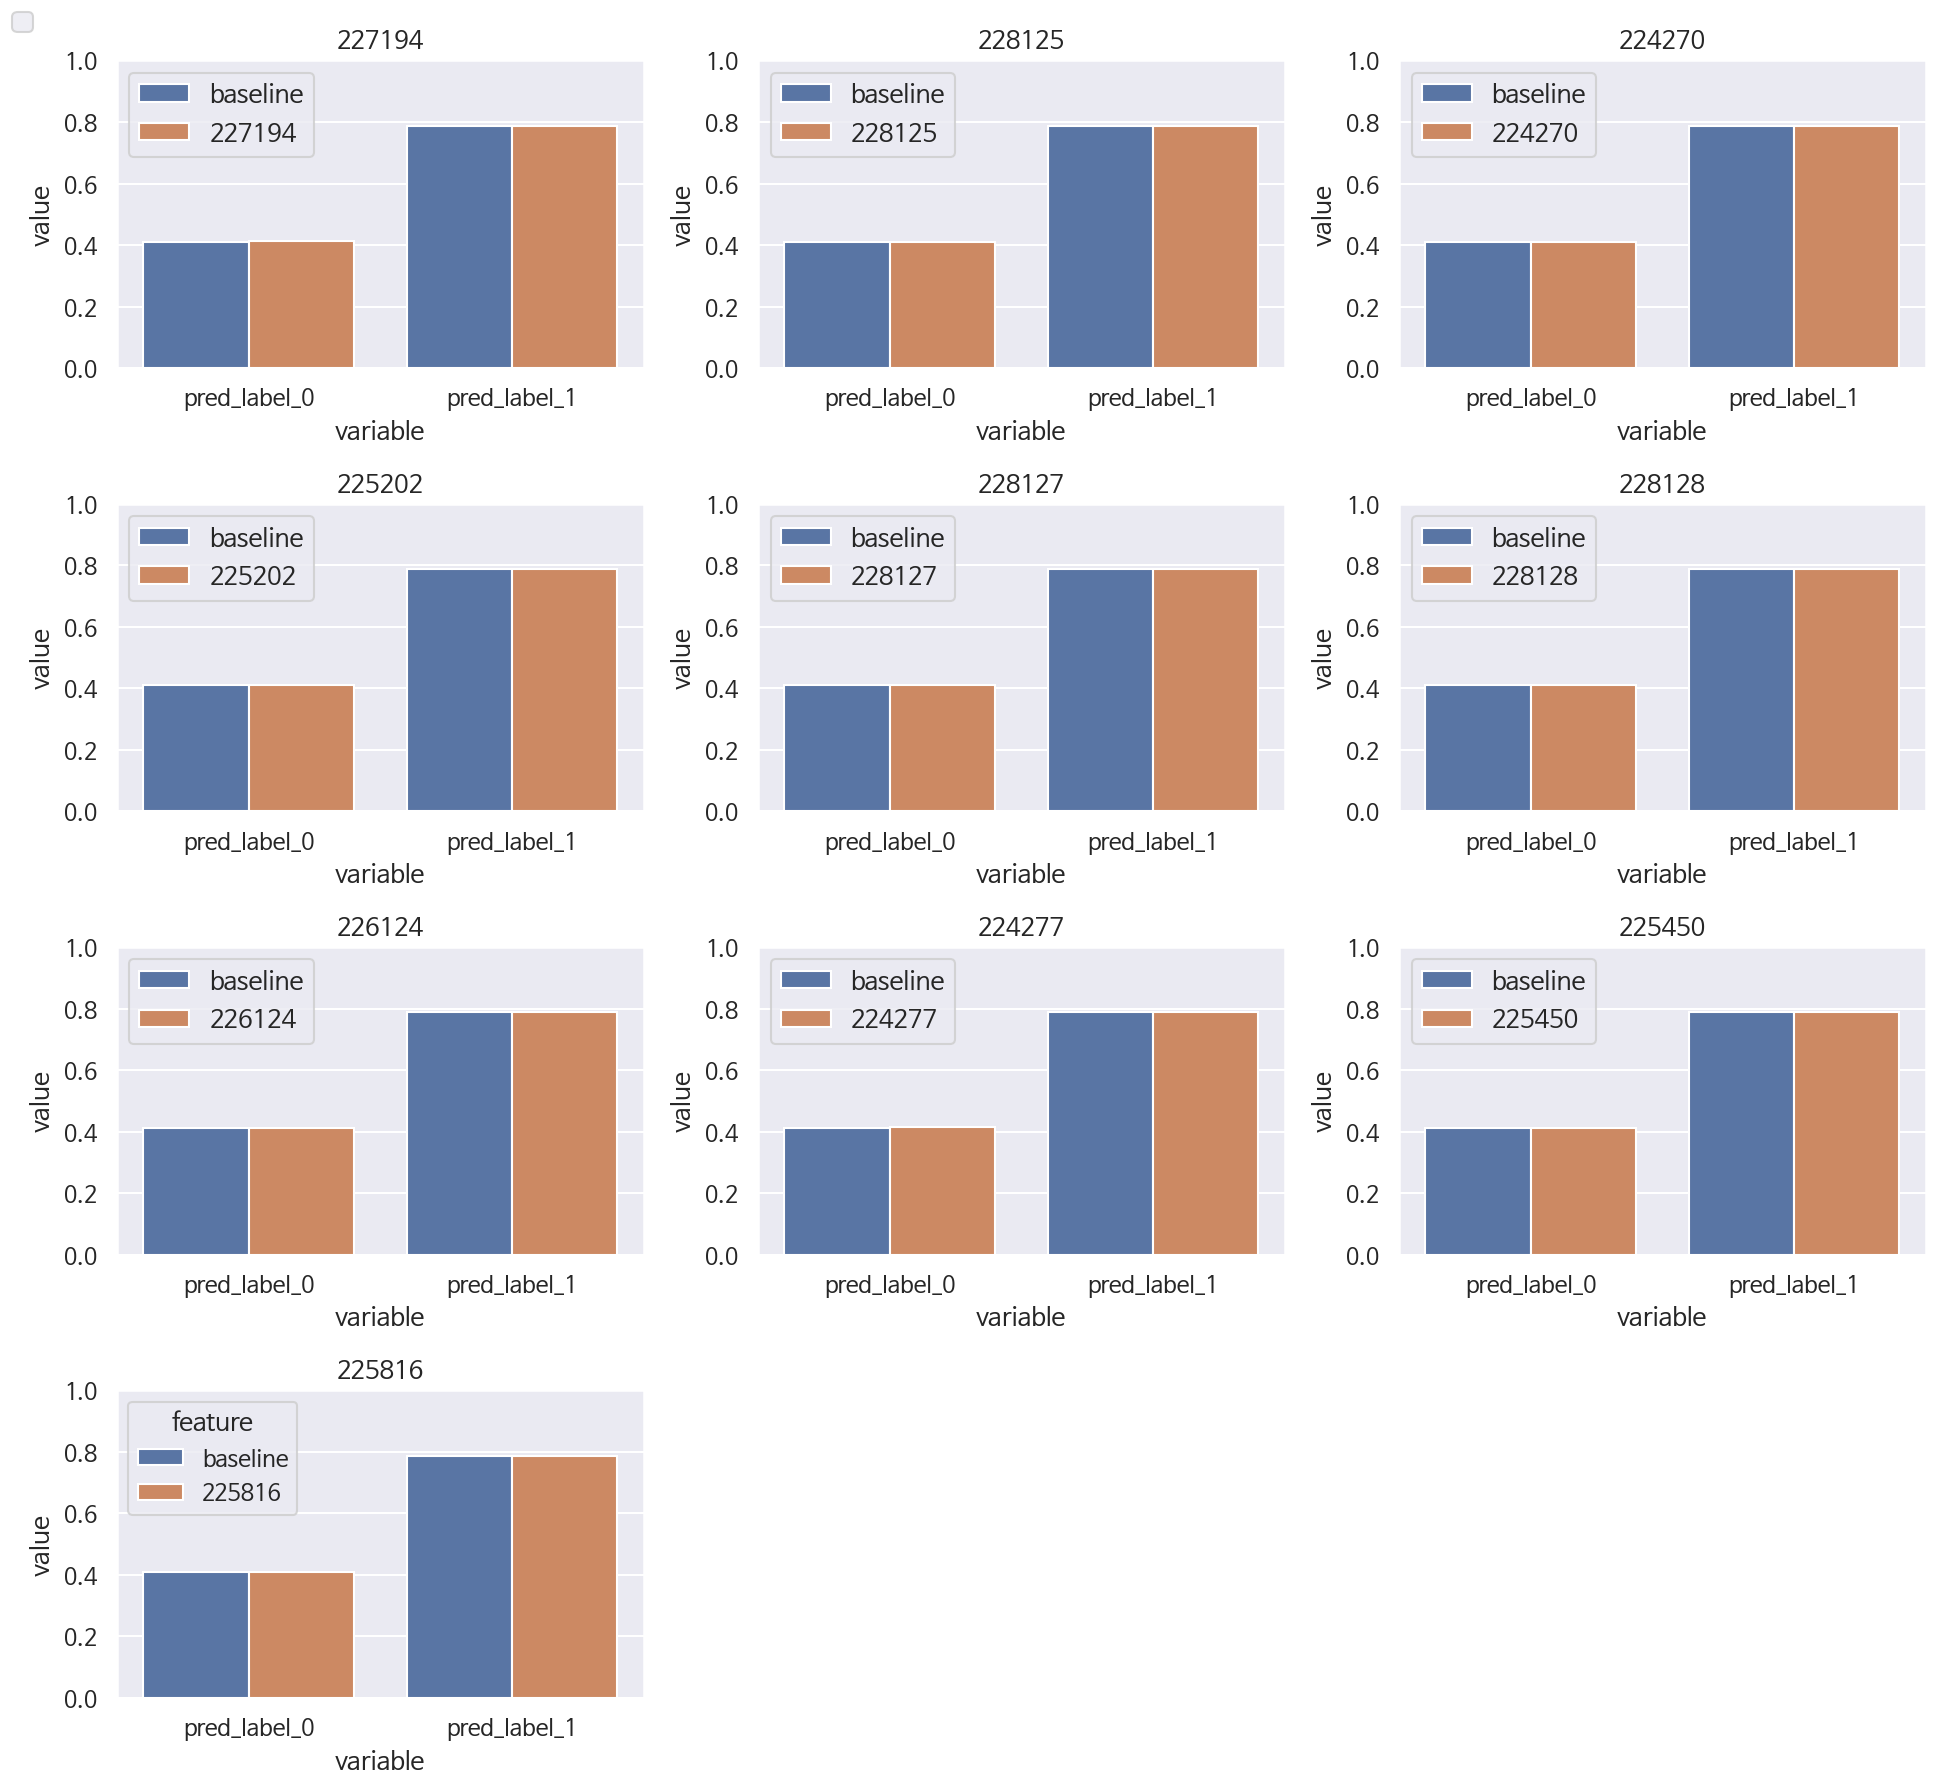

In [81]:
change(PRO_list,1,0)

## LAB - top10

10it [00:04,  2.35it/s]
No handles with labels found to put in legend.


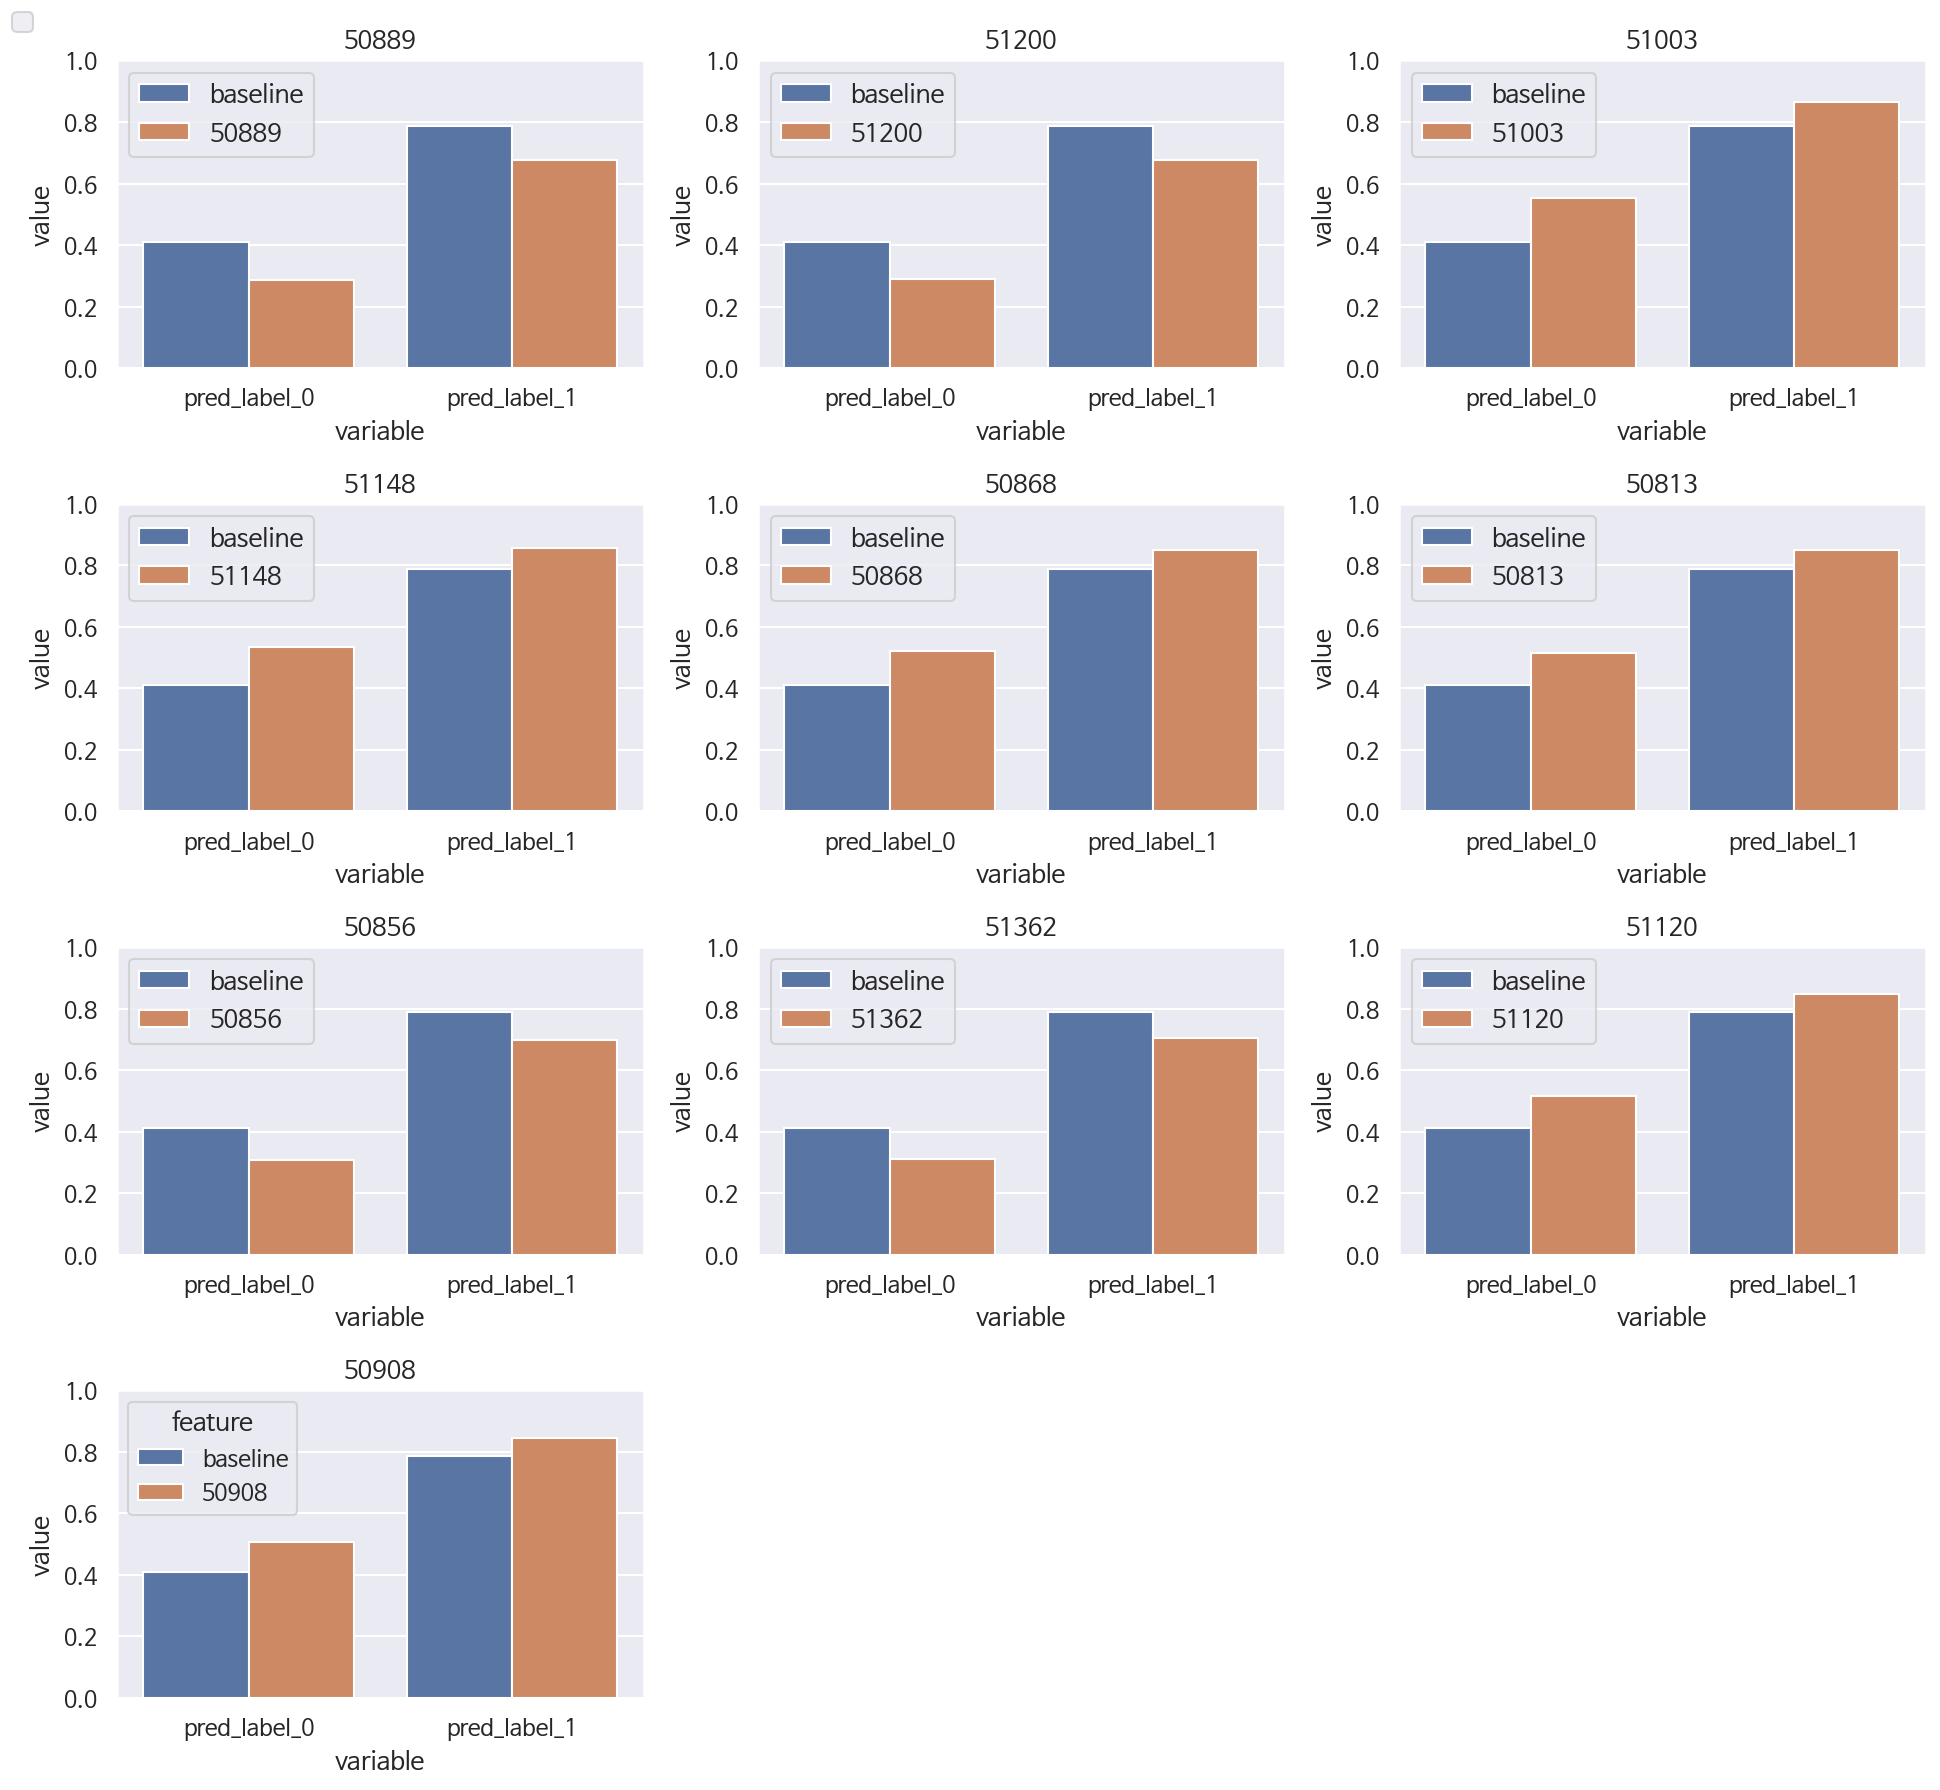

In [82]:
change(LAB_list,0,1)

10it [00:04,  2.28it/s]
No handles with labels found to put in legend.


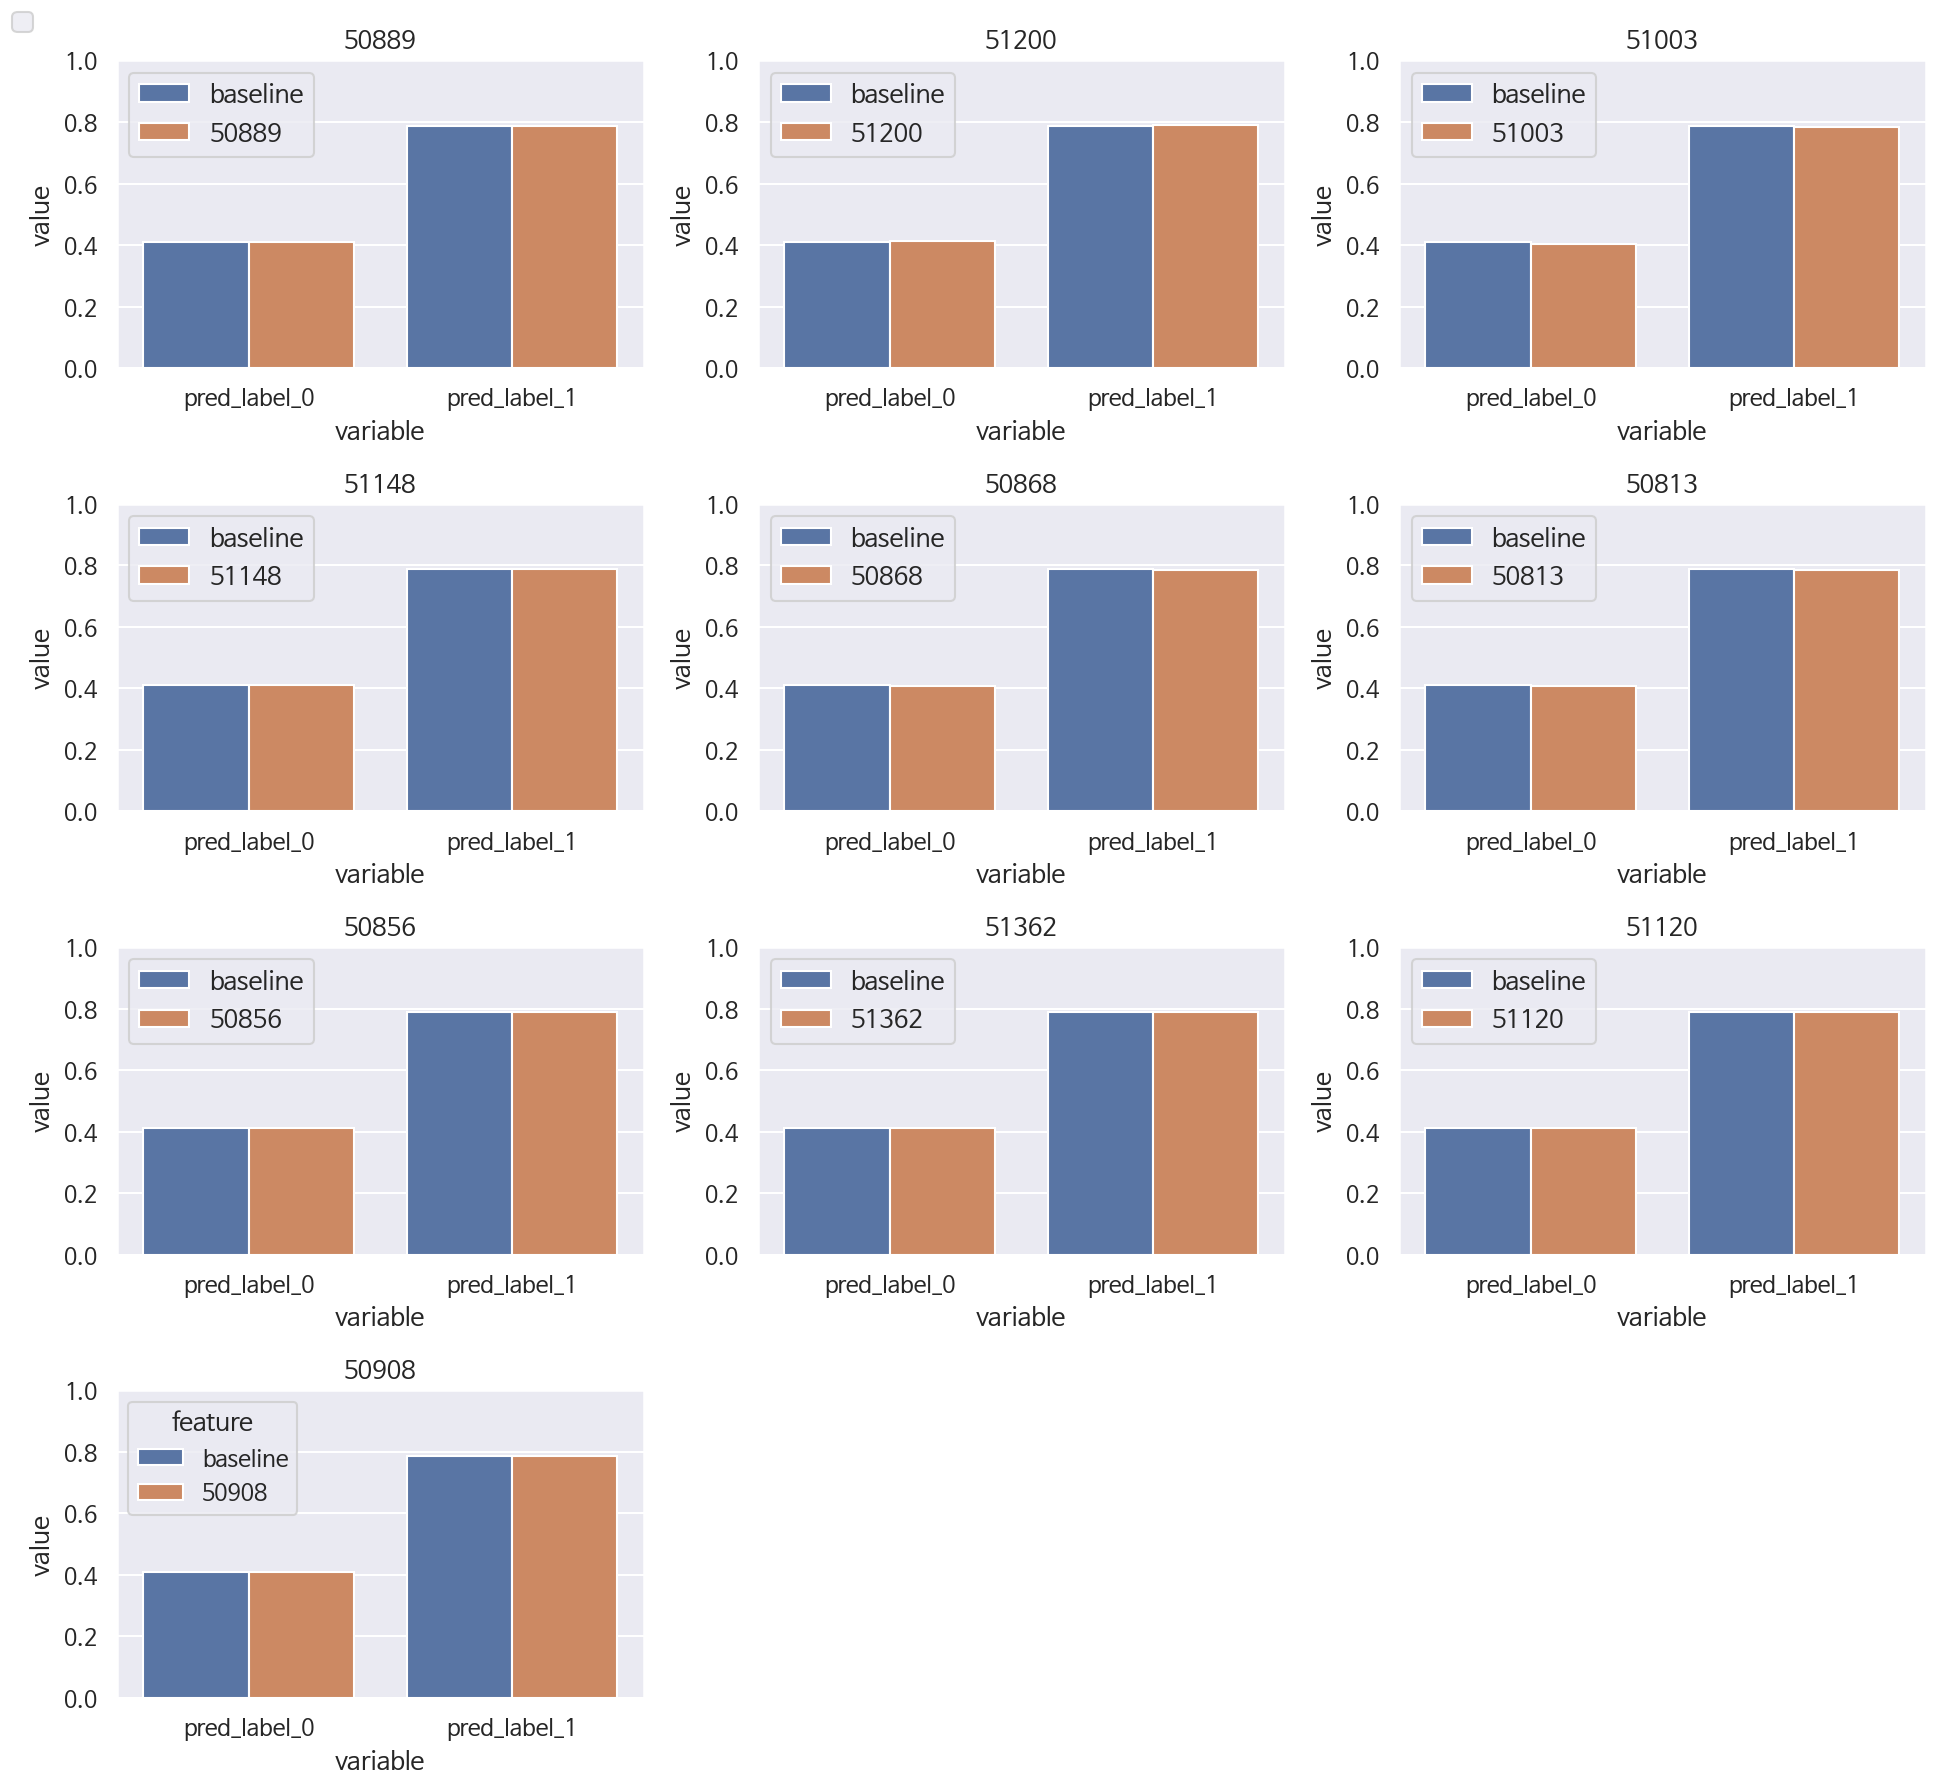

In [83]:
change(LAB_list,1,0)

# 1 ~ 5 reversed - 그래프
- 1 ~ 5 reversed 방법으로 뽑은 top10 item에 대해 changing values 한 후 사망자, 생존자별 평균예측값 비교

In [63]:
# 5) All reversed / d1d5 / d6d10에 따라 다르게 실행 

total_data = pd.read_csv('total_data_7727.csv')

# ---------------------------------------
d1d5_feature = df_d1d5['feature'].tolist()
# ---------------------------------------

# LAB, PRE, PRO의 item_list 생성 
LAB_item = total_data[total_data['TYPE']=='LAB']['ITEMID'].unique()
PRE_item = total_data[total_data['TYPE']=='PRE']['ITEMID'].unique()
PRO_item = total_data[total_data['TYPE']=='PRO']['ITEMID'].unique()

LAB_list = []
PRE_list = []
PRO_list = []

# ---------------------------------------
for i in d1d5_feature:
# ---------------------------------------
    if i in LAB_item:
        LAB_list.append(i)
    elif i in PRE_item:
        PRE_list.append(i)
    else:
        PRO_list.append(i)

## PRE - top10

10it [00:04,  2.30it/s]
No handles with labels found to put in legend.


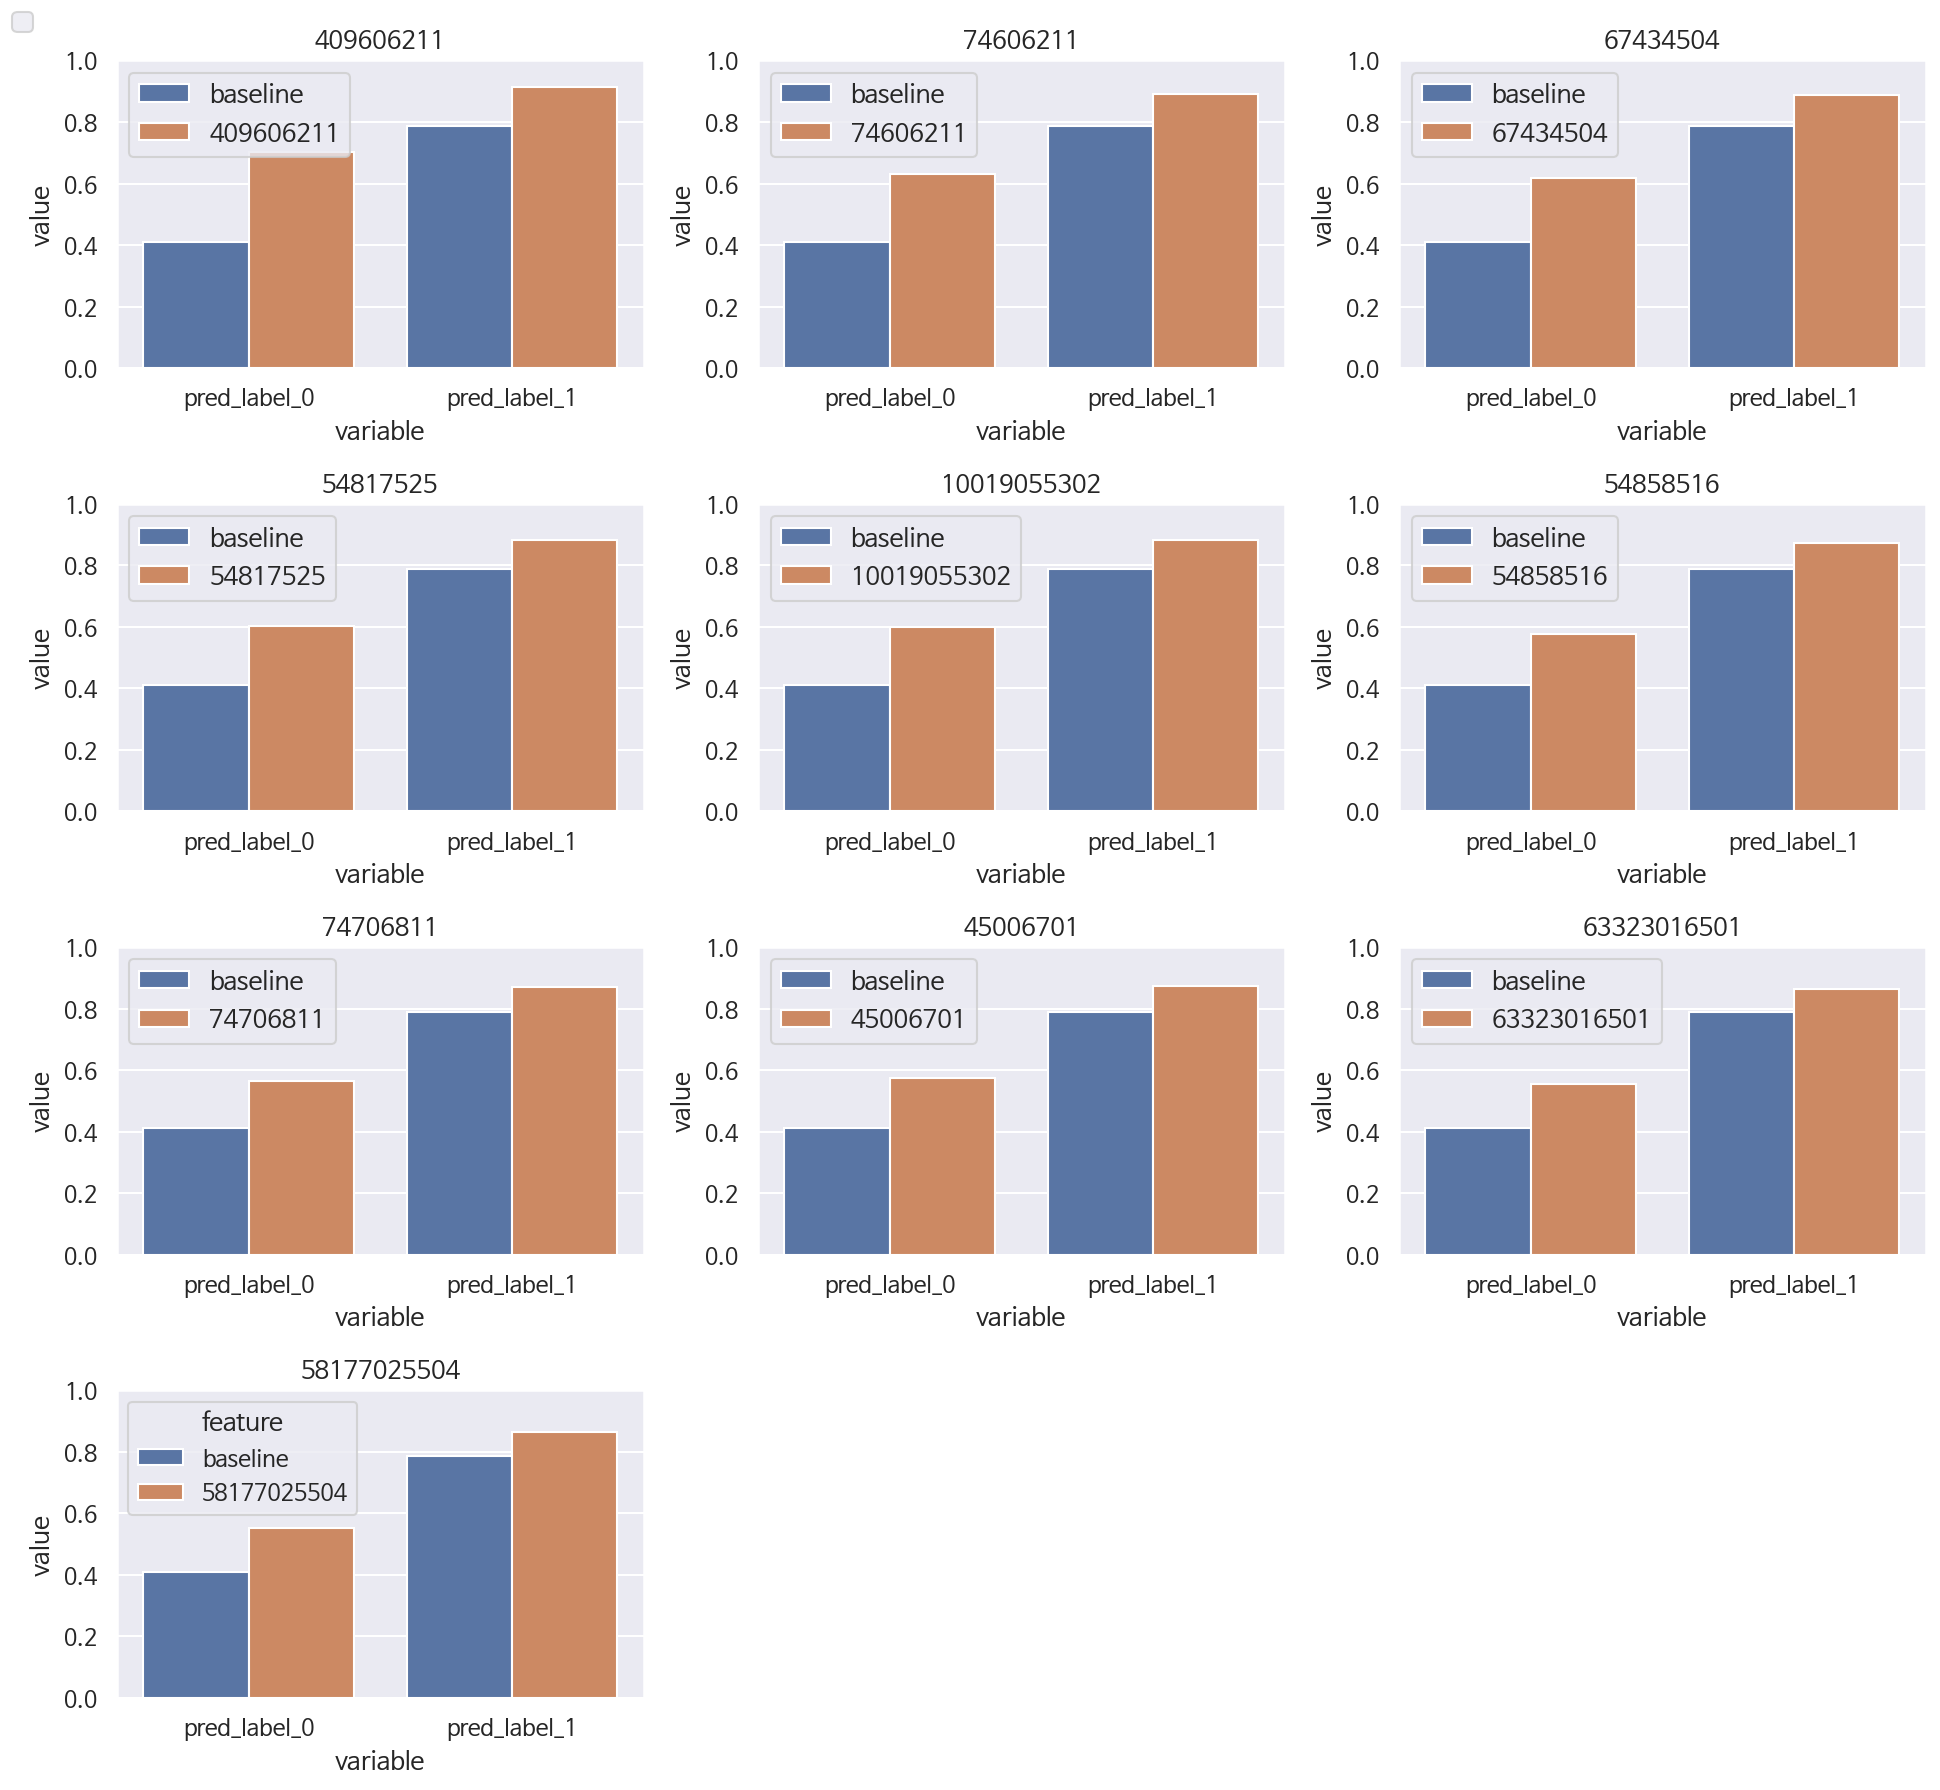

In [64]:
change(PRE_list,0,1)

10it [00:04,  2.37it/s]
No handles with labels found to put in legend.


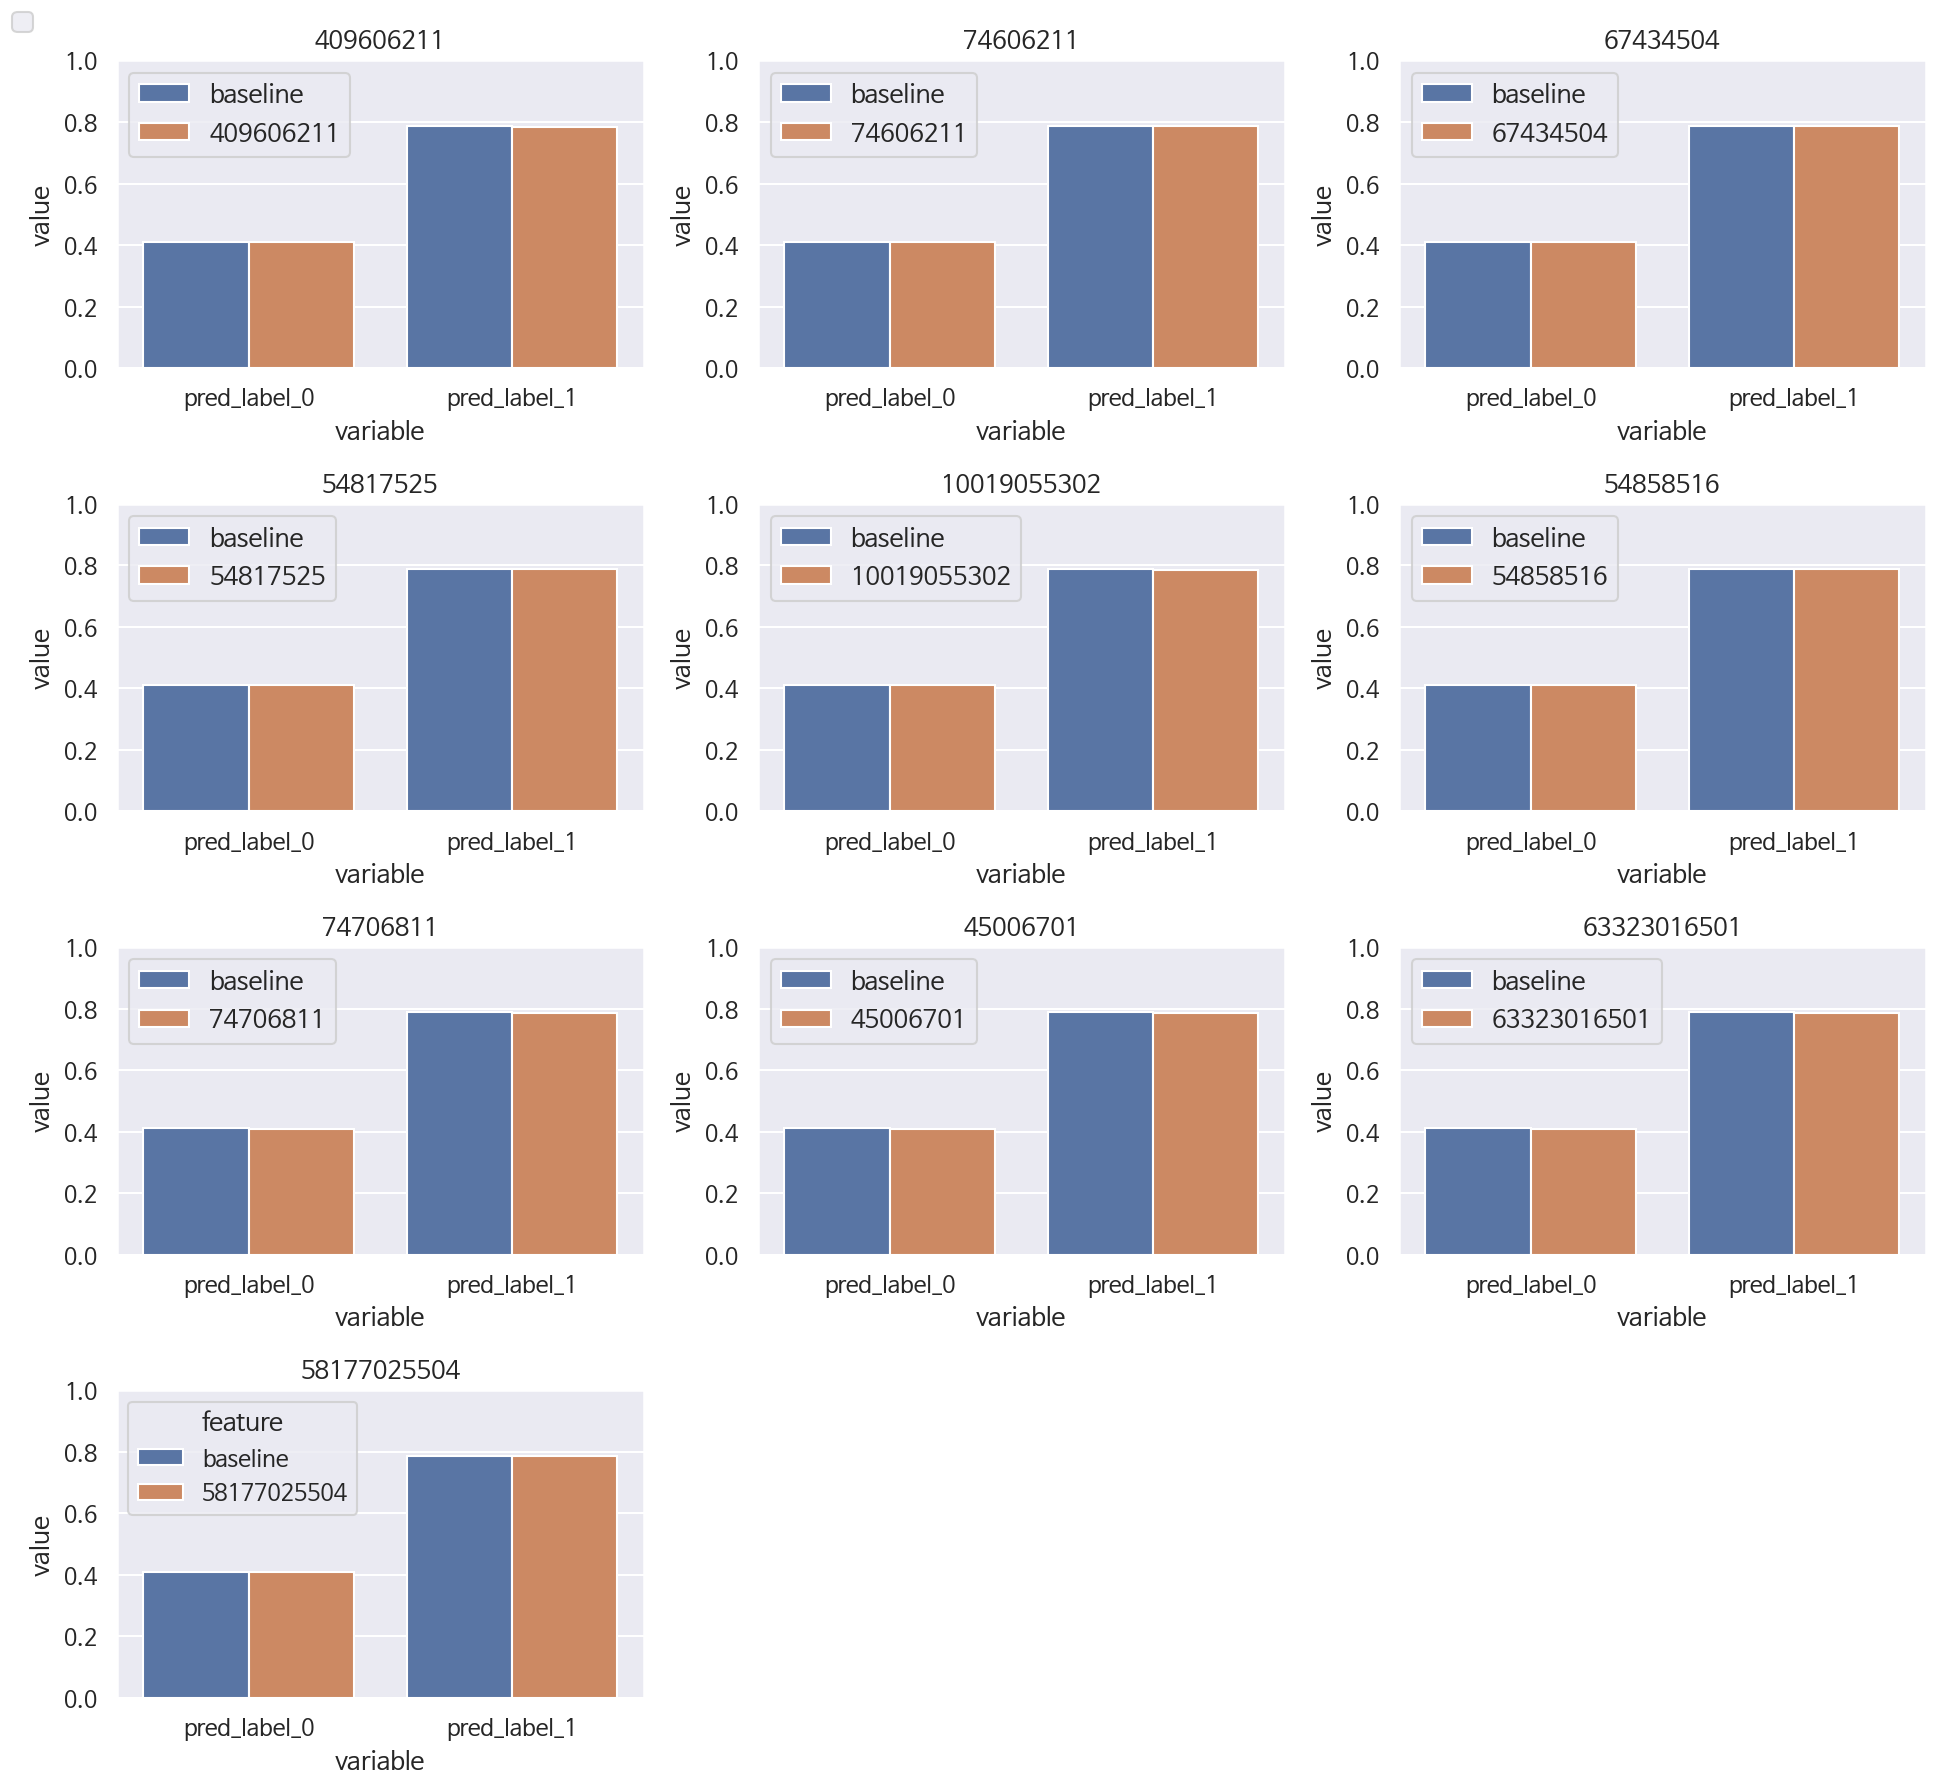

In [65]:
change(PRE_list,1,0)

## PRO - top10

10it [00:04,  2.31it/s]
No handles with labels found to put in legend.


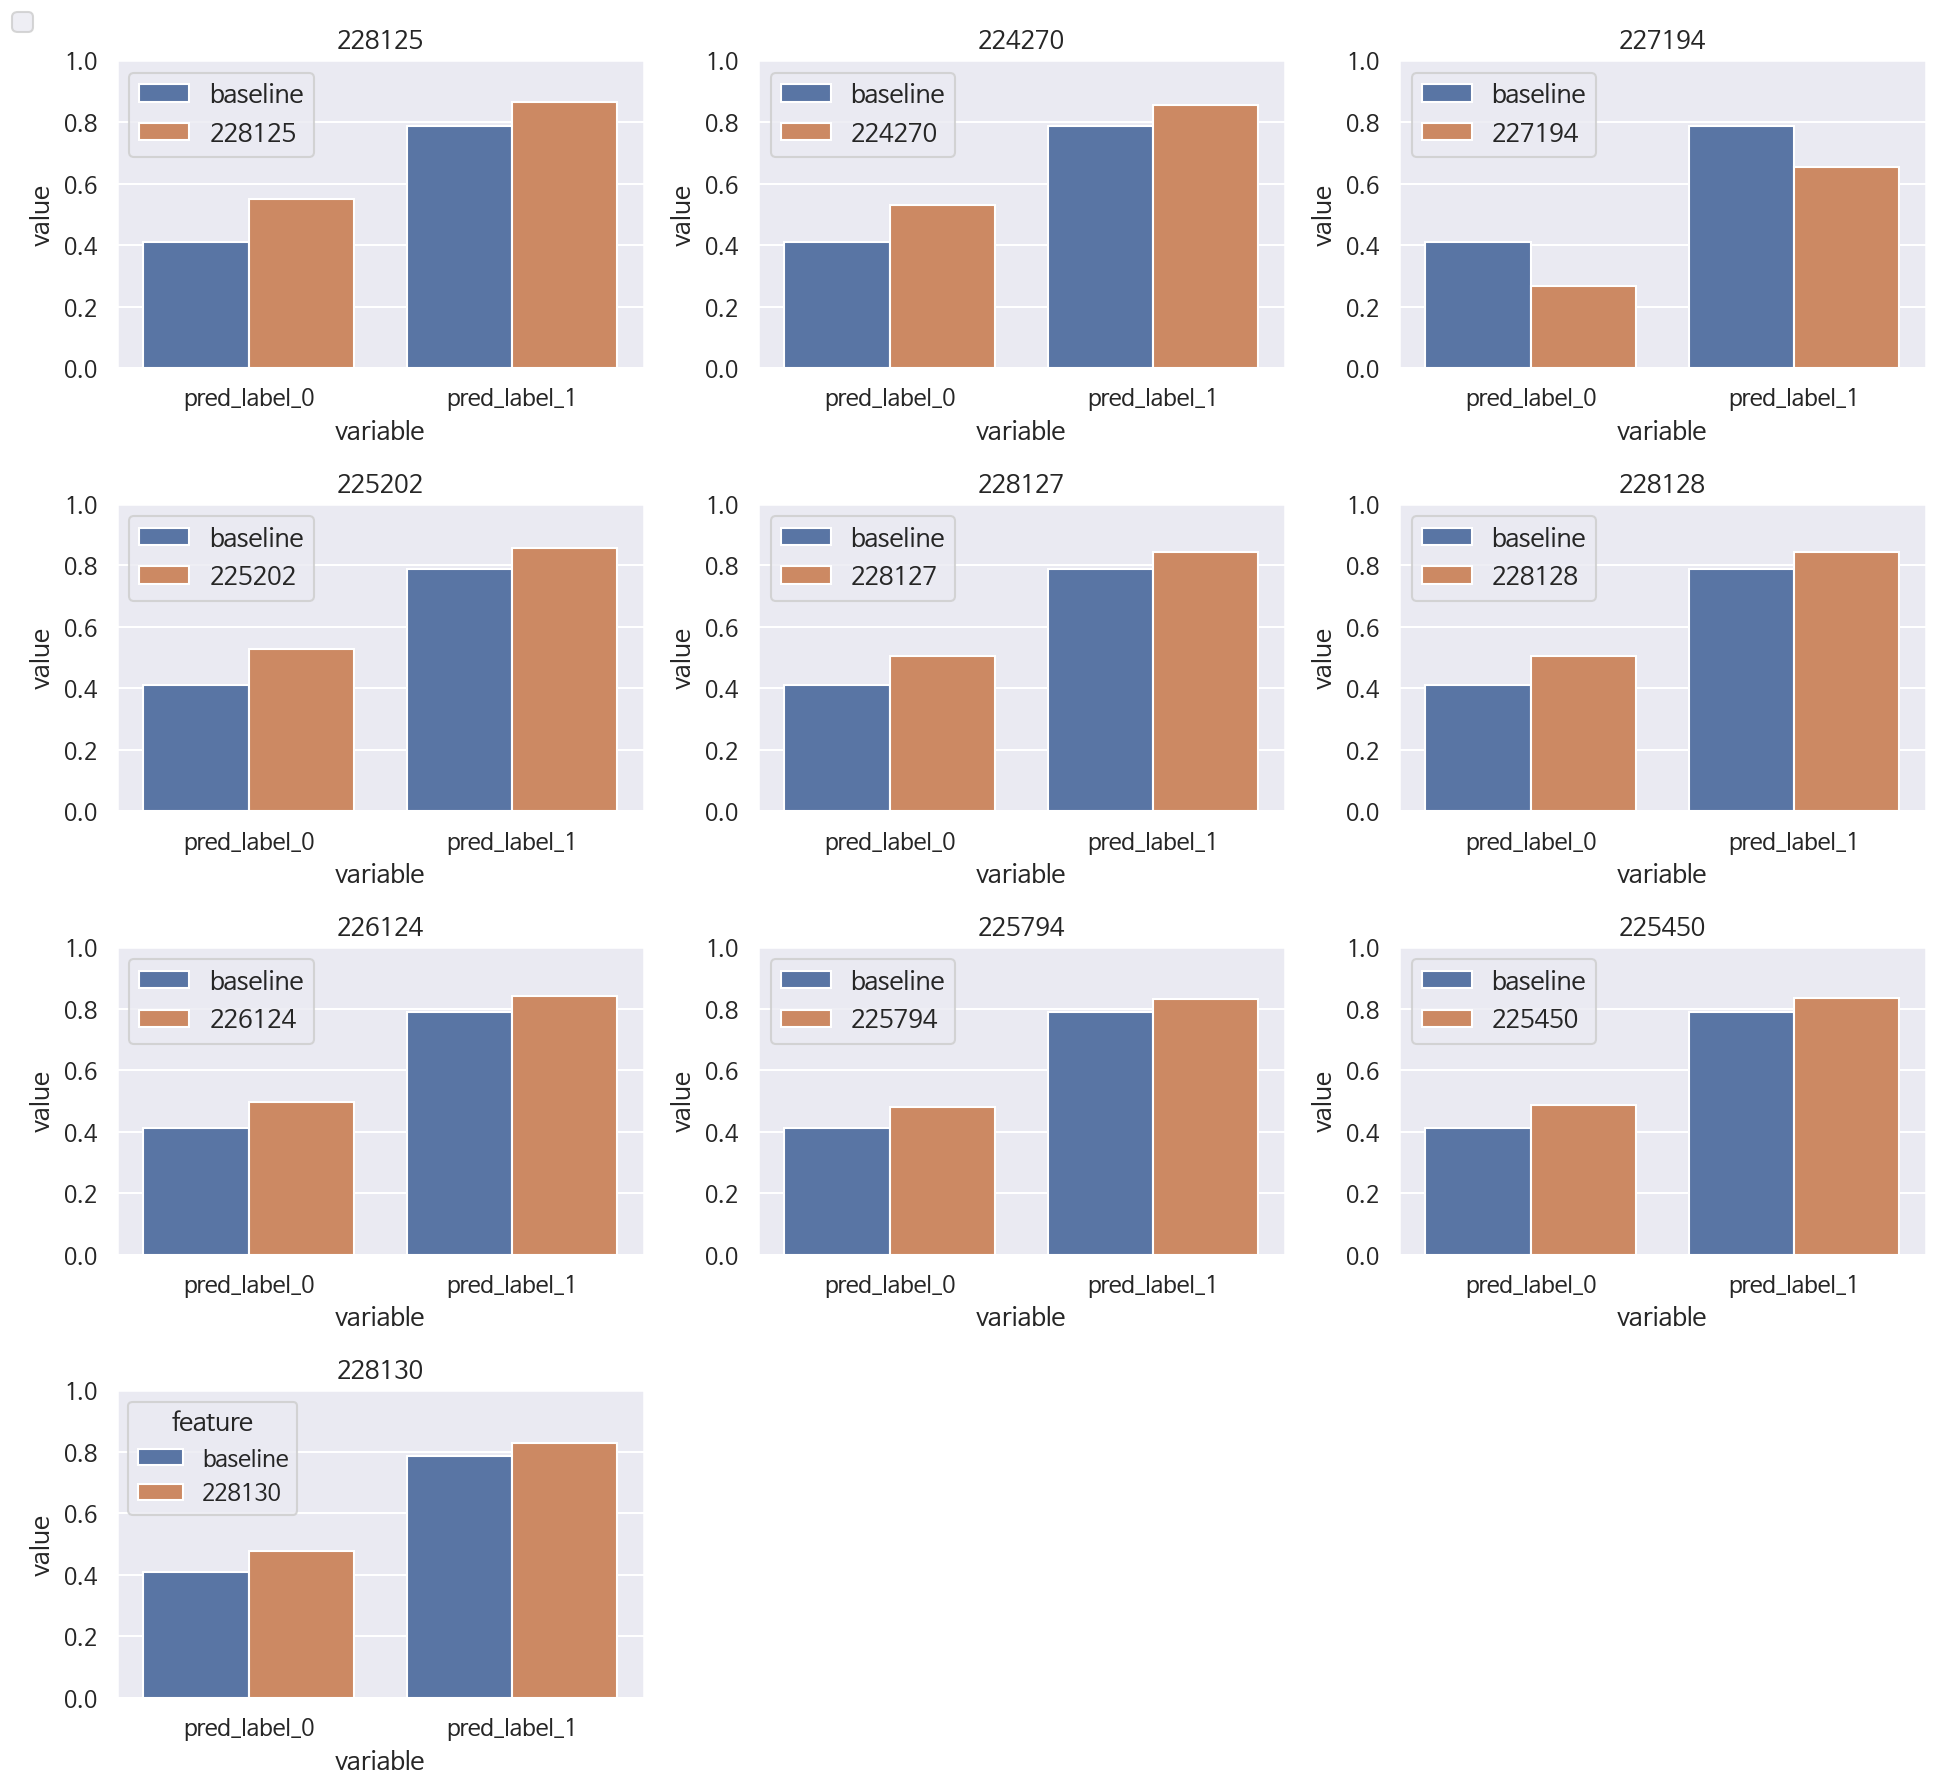

In [66]:
change(PRO_list,0,1)

10it [00:04,  2.37it/s]
No handles with labels found to put in legend.


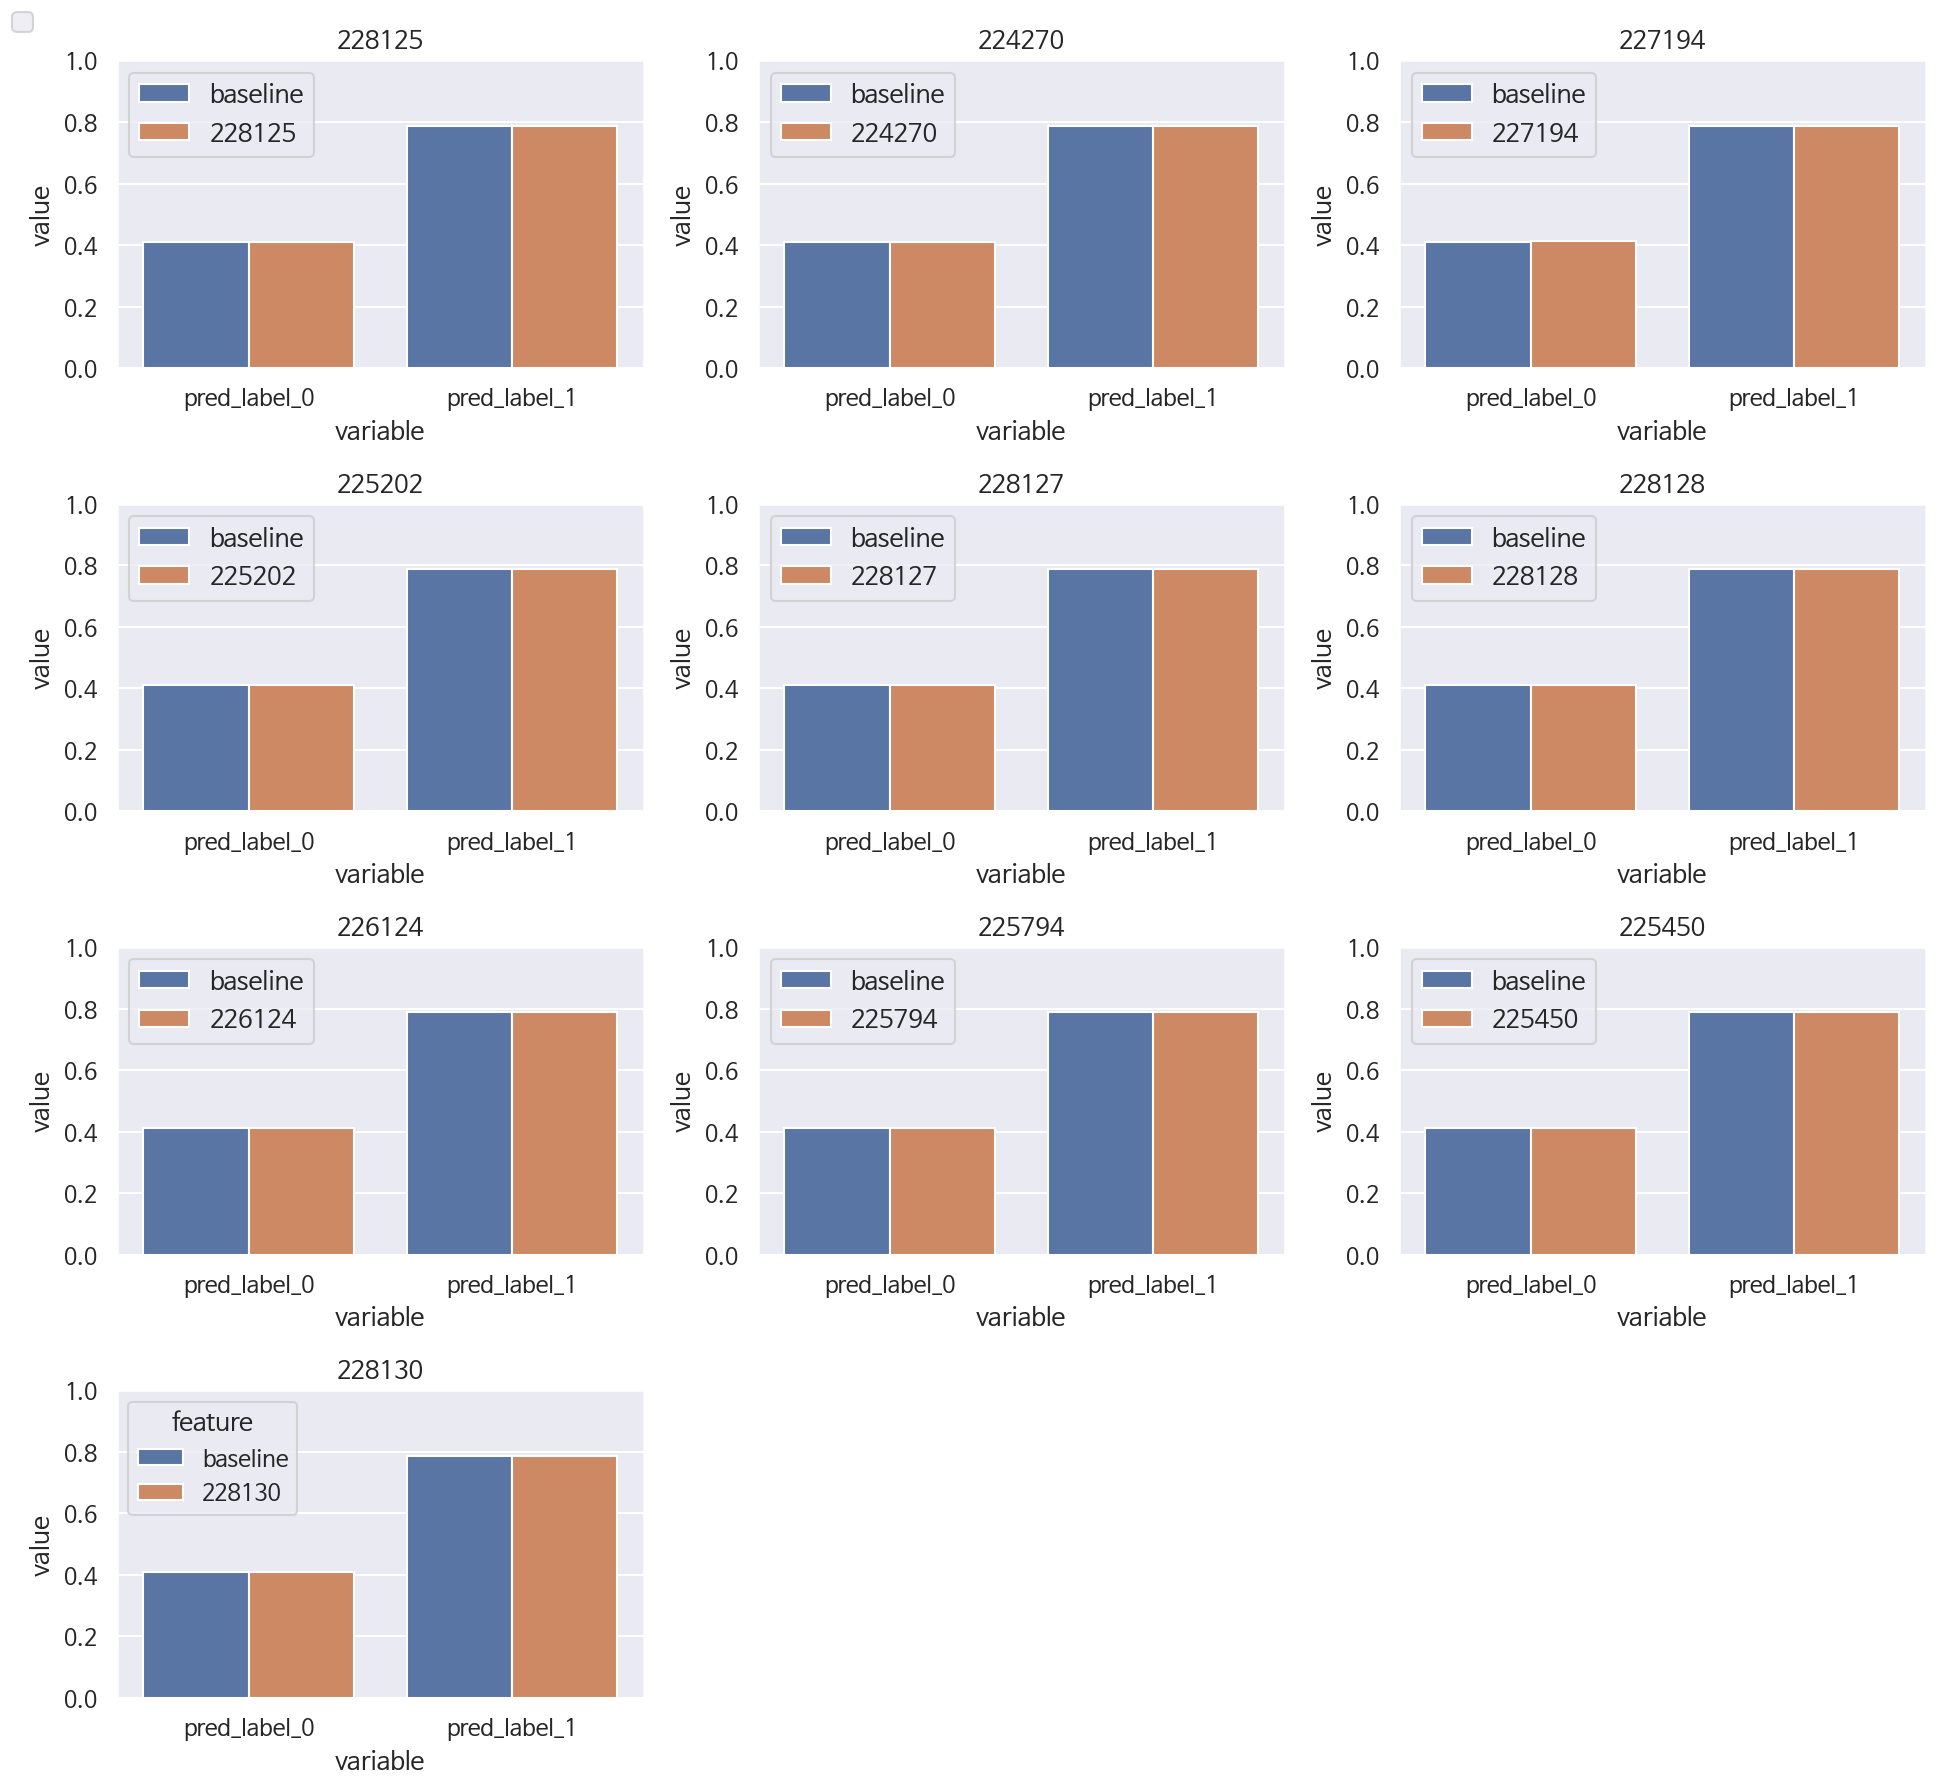

In [67]:
change(PRO_list,1,0)

## LAB - top10

10it [00:04,  2.38it/s]
No handles with labels found to put in legend.


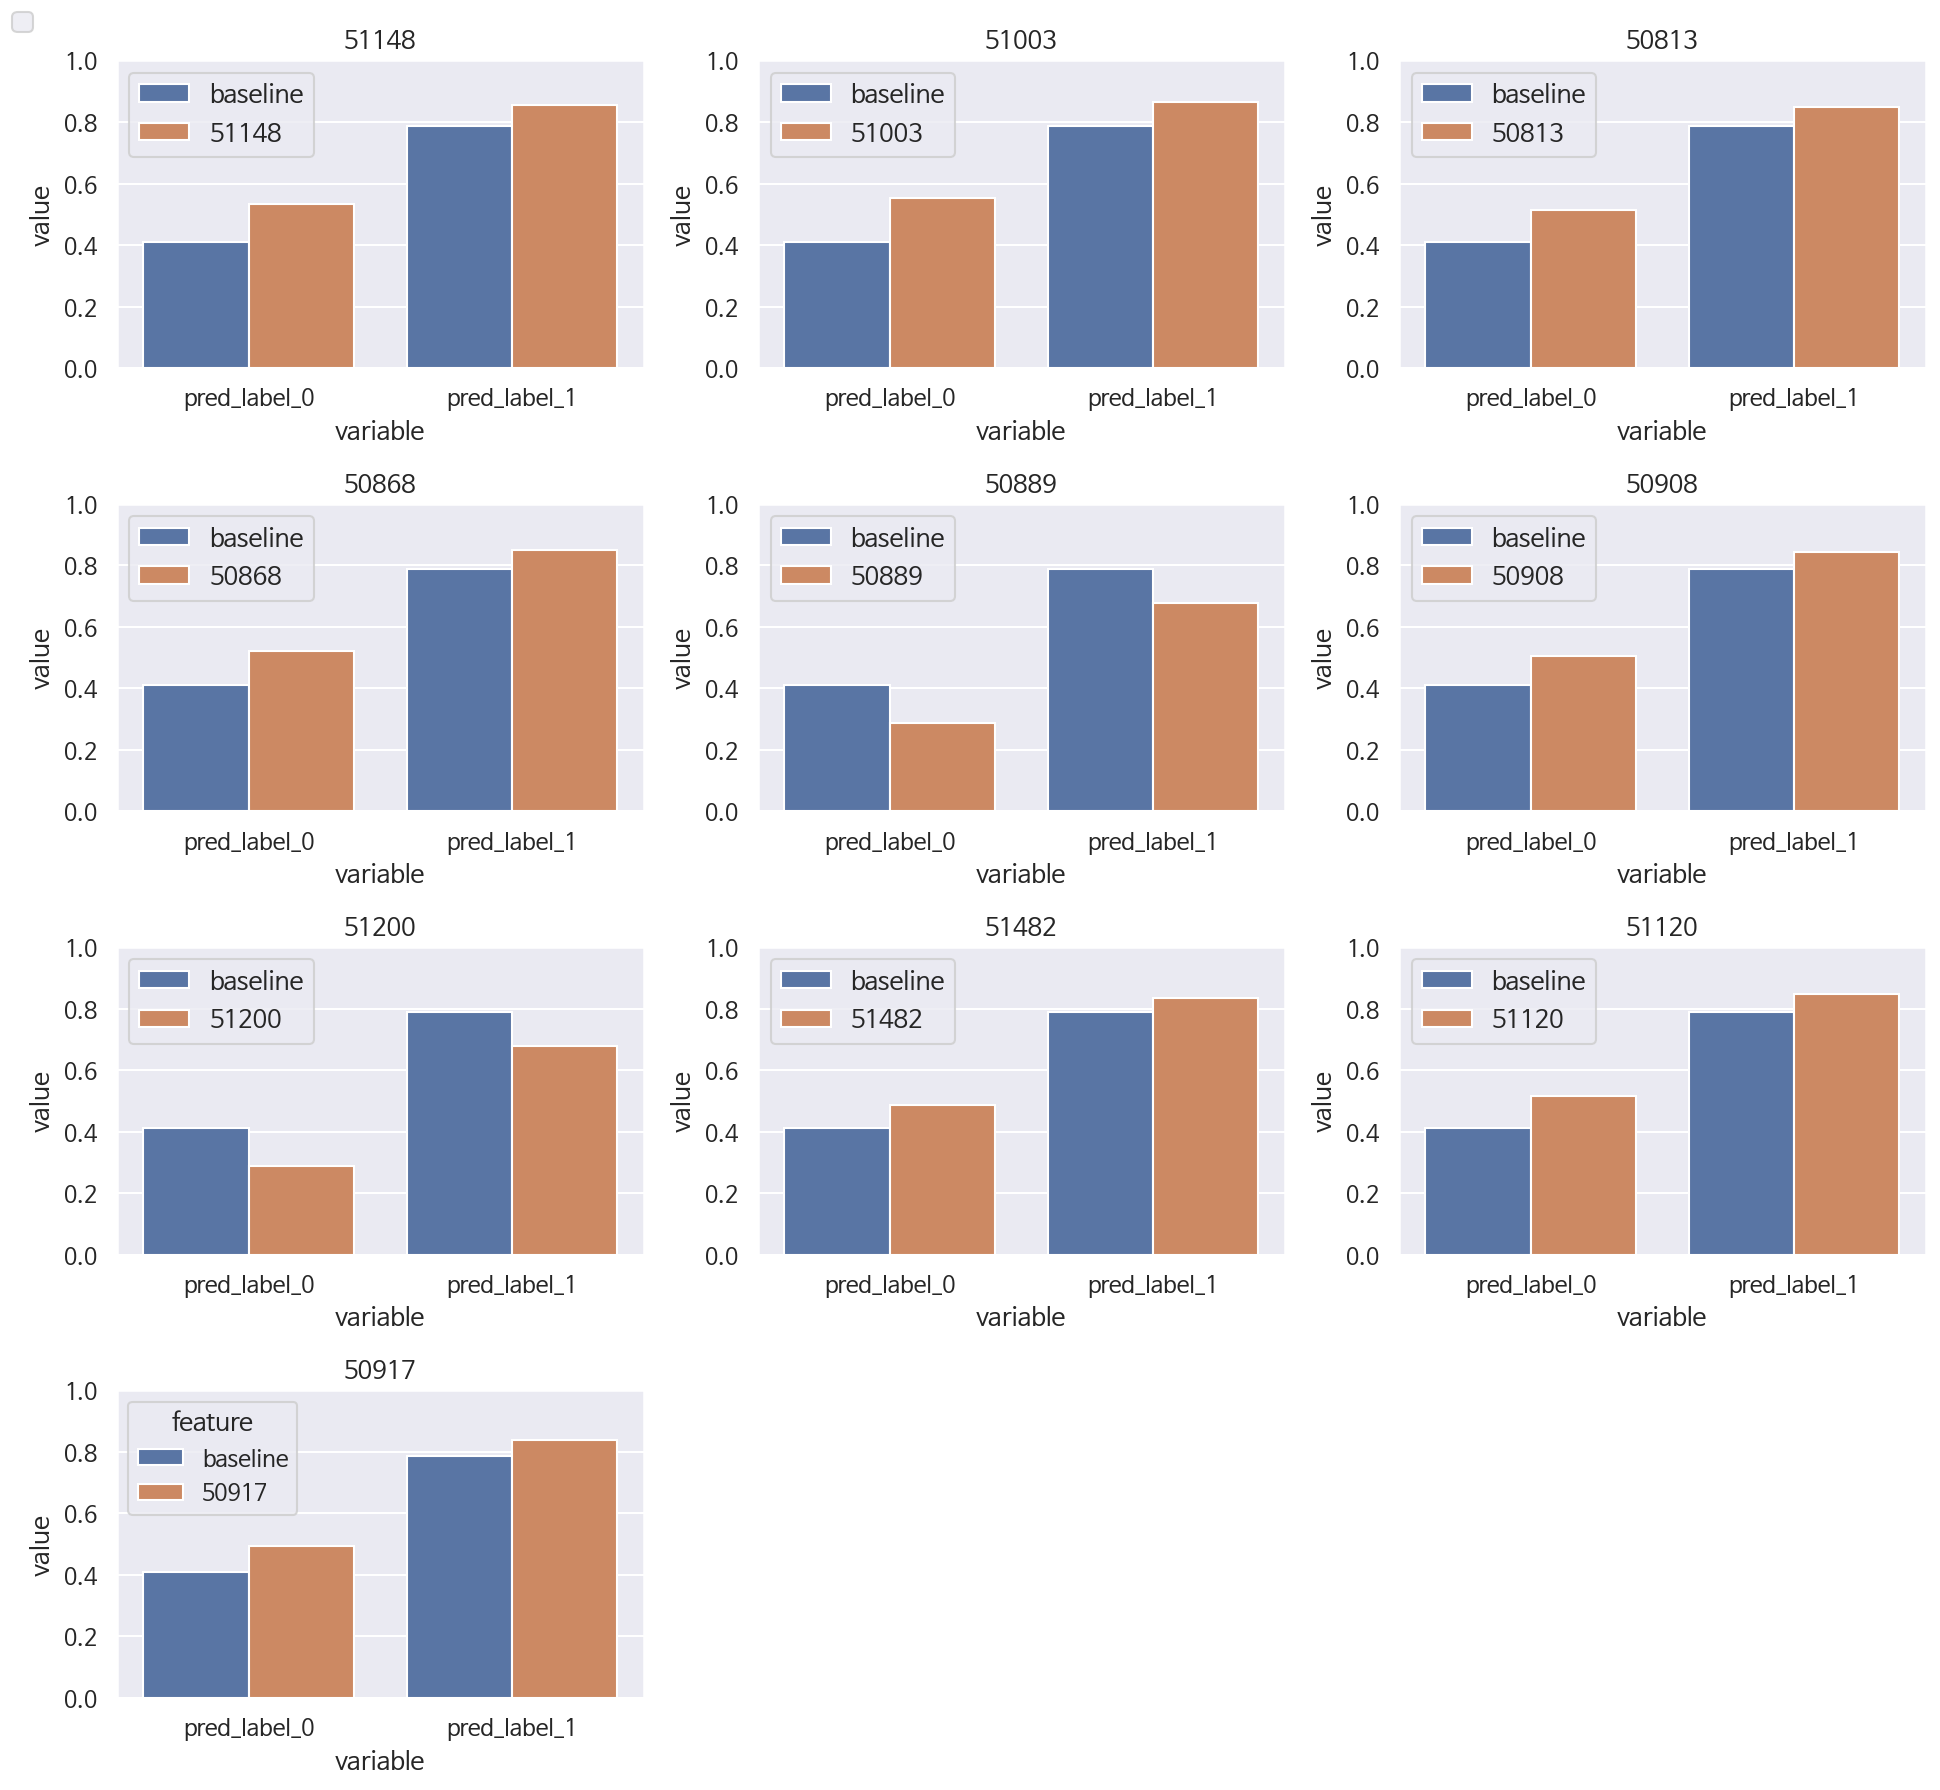

In [68]:
change(LAB_list,0,1)

10it [00:04,  2.32it/s]
No handles with labels found to put in legend.


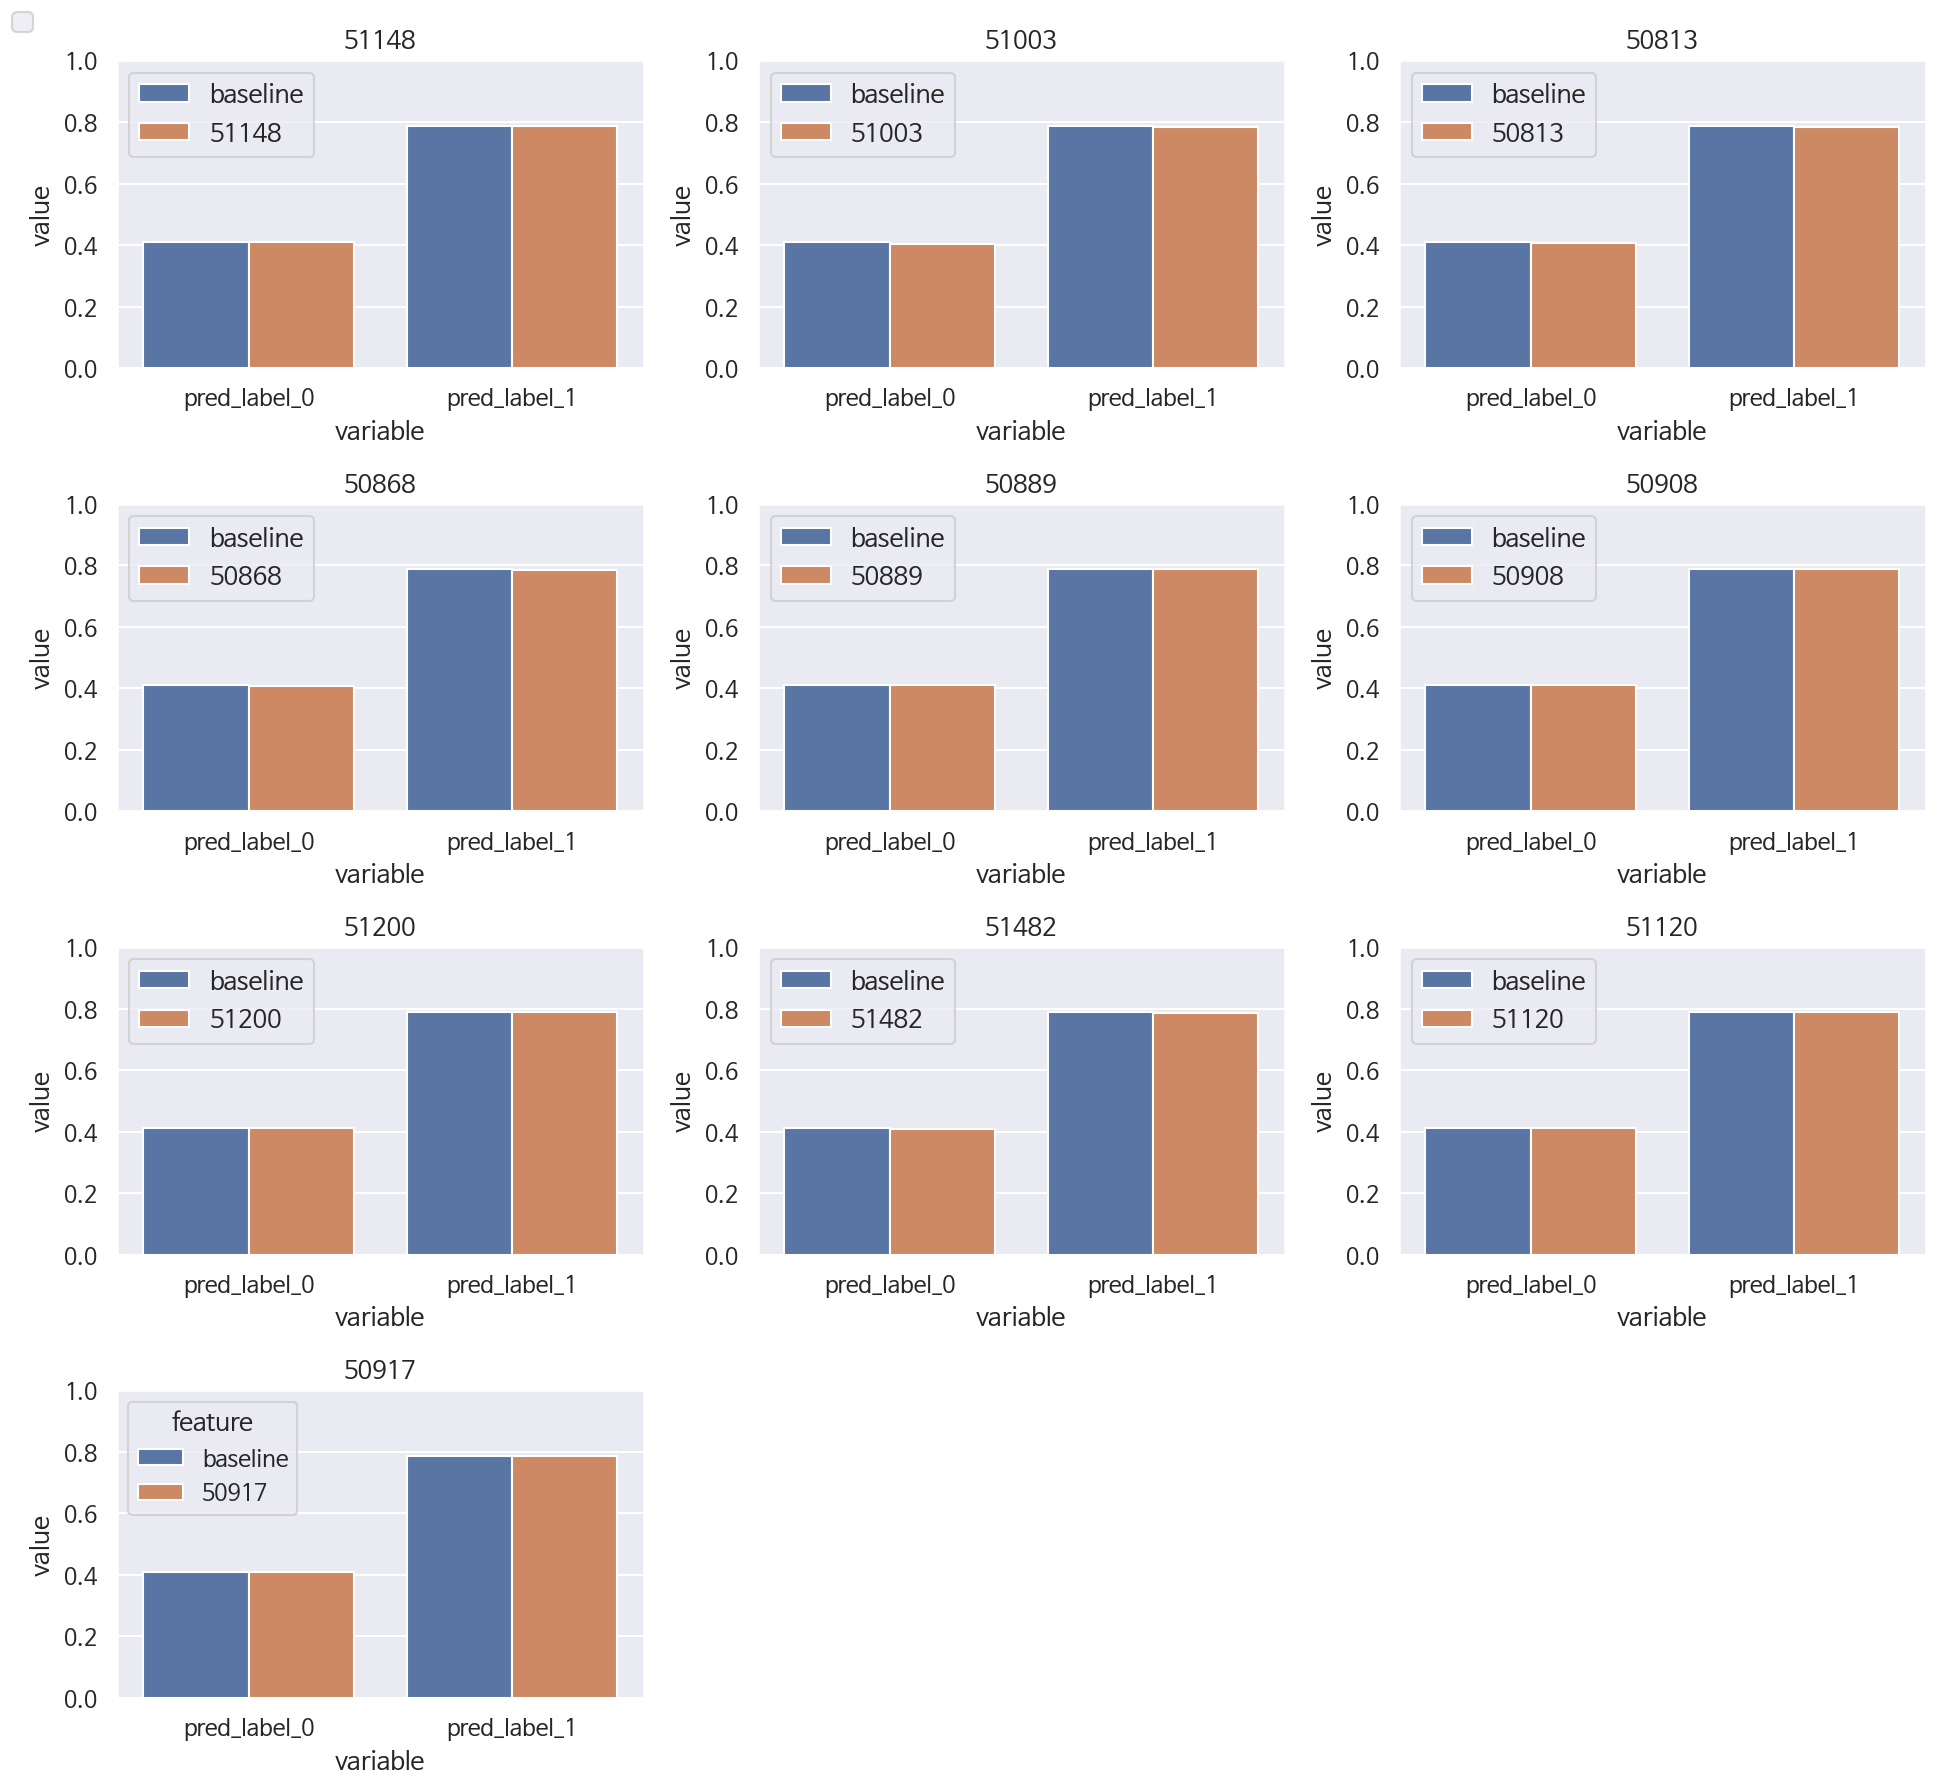

In [69]:
change(LAB_list,1,0)

# 6 ~ 10 reversed - 그래프
- 6 ~ 10 reversed 방법으로 뽑은 top10 item에 대해 changing values 한 후 사망자, 생존자별 평균예측값 비교

In [70]:
# 5) All reversed / d1d5 / d6d10에 따라 다르게 실행 

total_data = pd.read_csv('total_data_7727.csv')

# ---------------------------------------
d6d10_feature = df_d6d10['feature'].tolist()
# ---------------------------------------

# LAB, PRE, PRO의 item_list 생성 
LAB_item = total_data[total_data['TYPE']=='LAB']['ITEMID'].unique()
PRE_item = total_data[total_data['TYPE']=='PRE']['ITEMID'].unique()
PRO_item = total_data[total_data['TYPE']=='PRO']['ITEMID'].unique()

LAB_list = []
PRE_list = []
PRO_list = []

# ---------------------------------------
for i in d6d10_feature:
# ---------------------------------------
    if i in LAB_item:
        LAB_list.append(i)
    elif i in PRE_item:
        PRE_list.append(i)
    else:
        PRO_list.append(i)

## PRE - top10

10it [00:04,  2.27it/s]
No handles with labels found to put in legend.


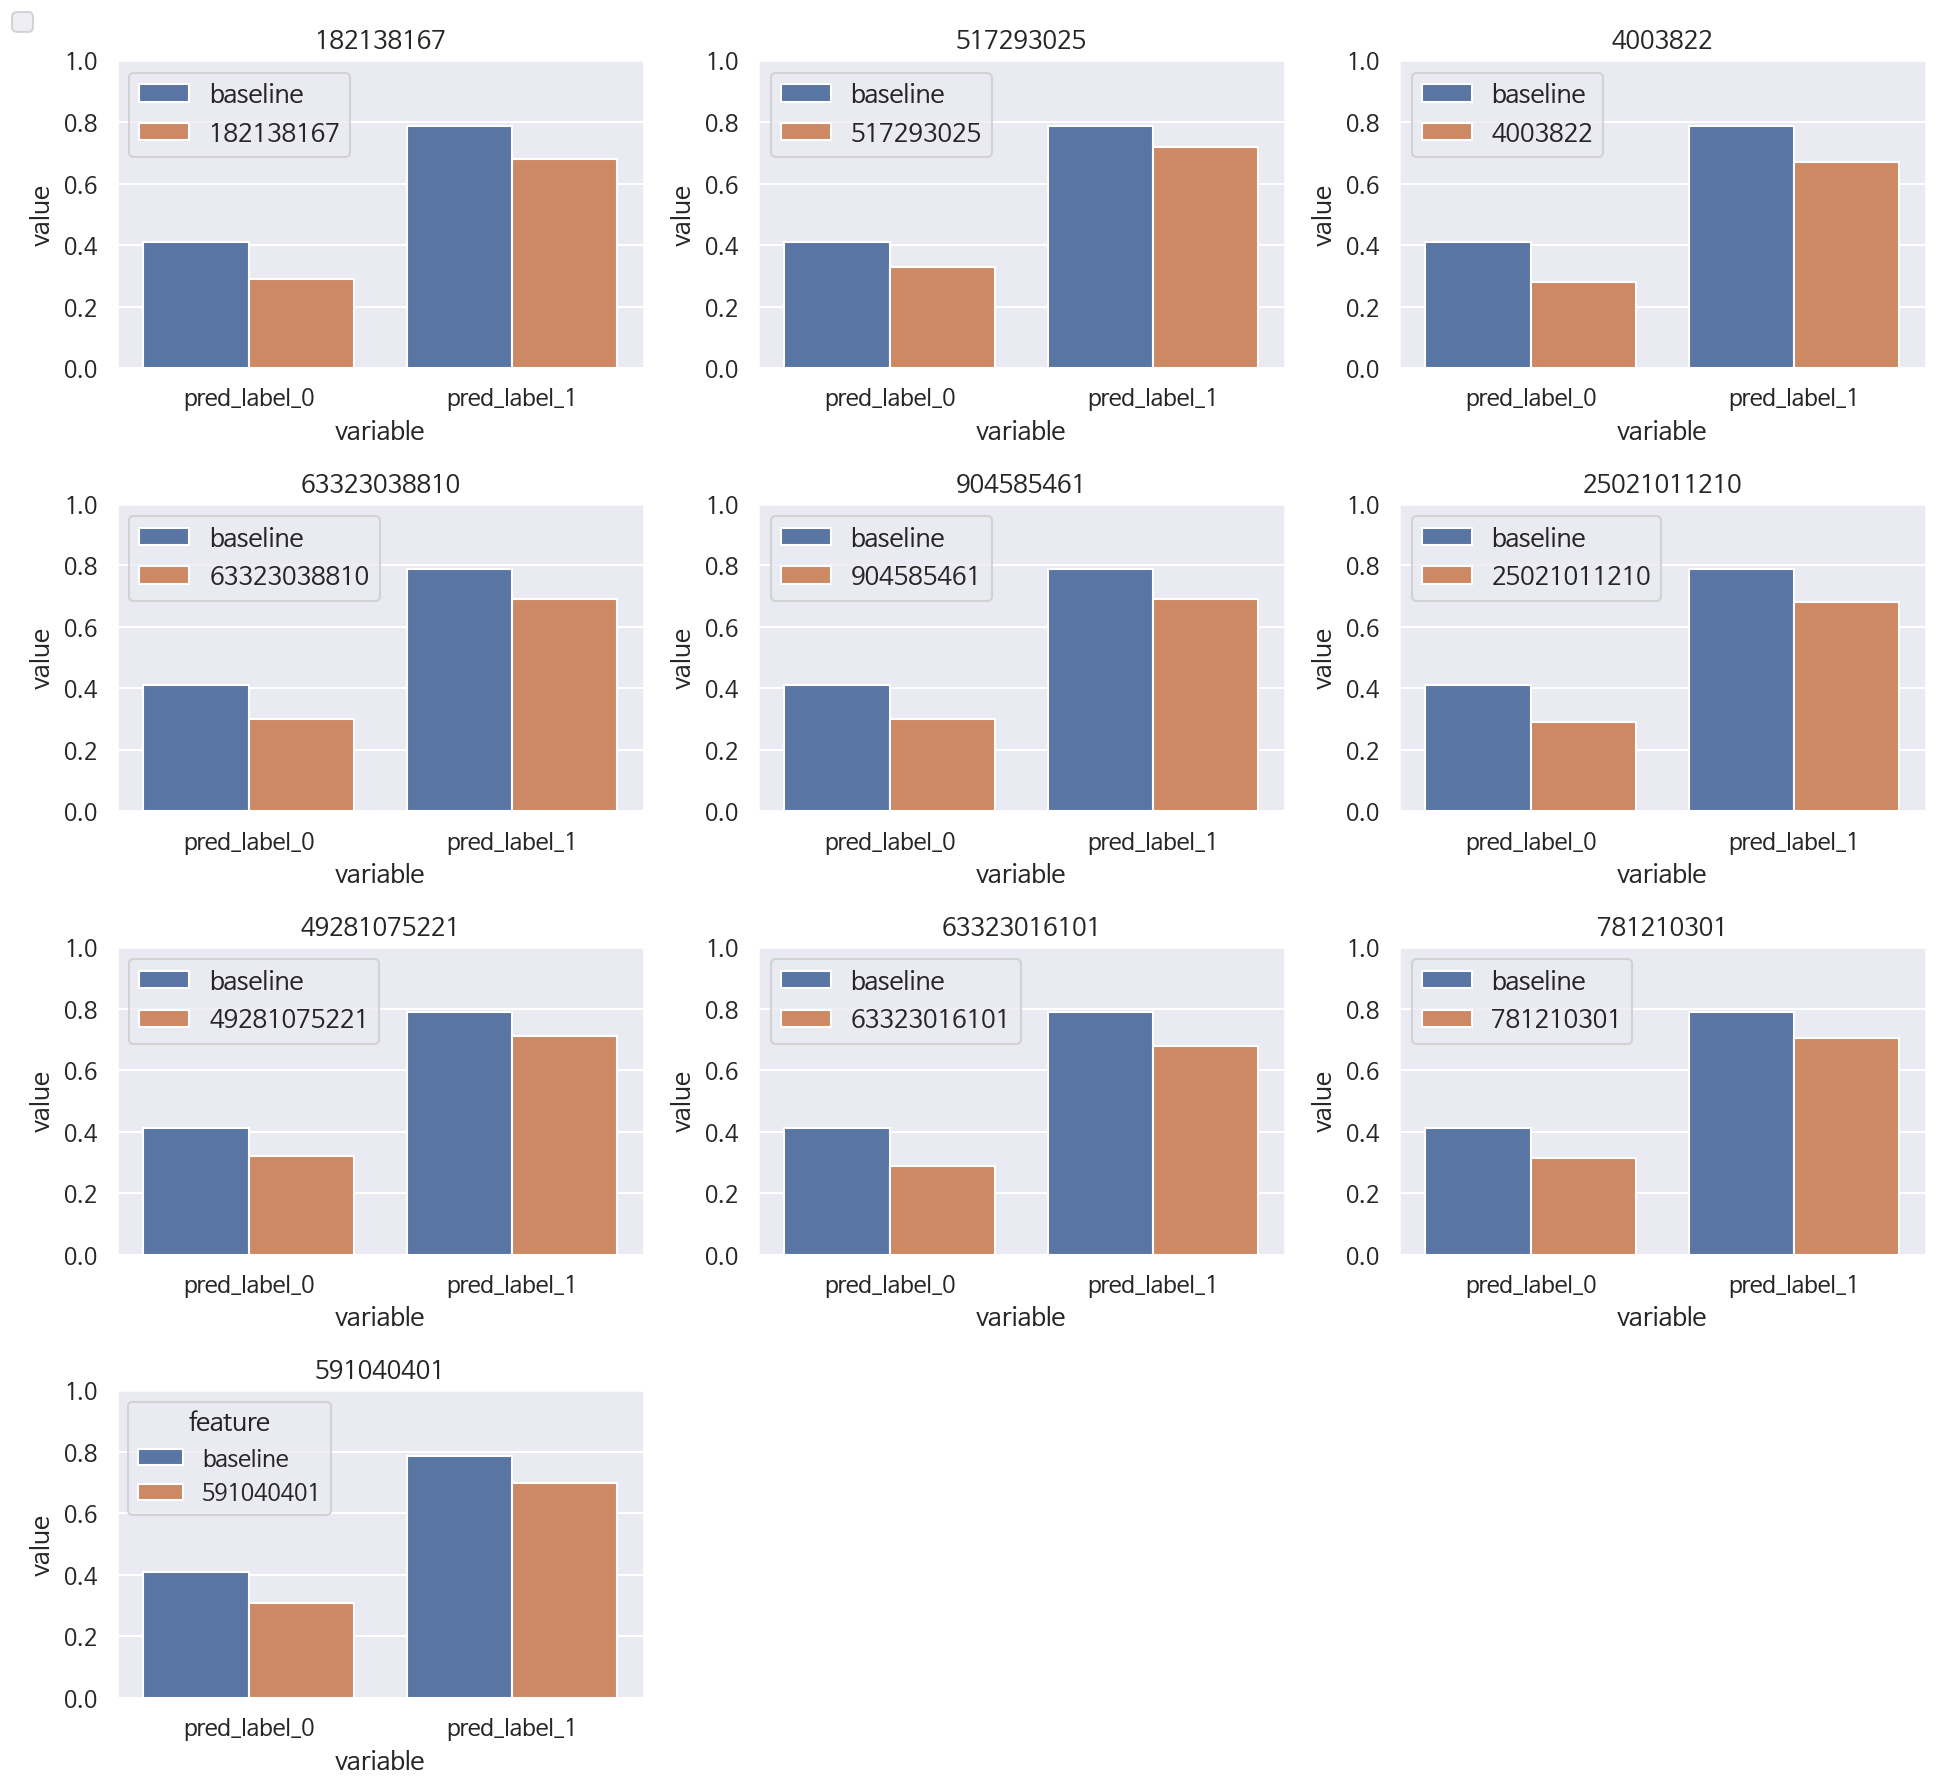

In [71]:
change(PRE_list,0,1)

10it [00:04,  2.36it/s]
No handles with labels found to put in legend.


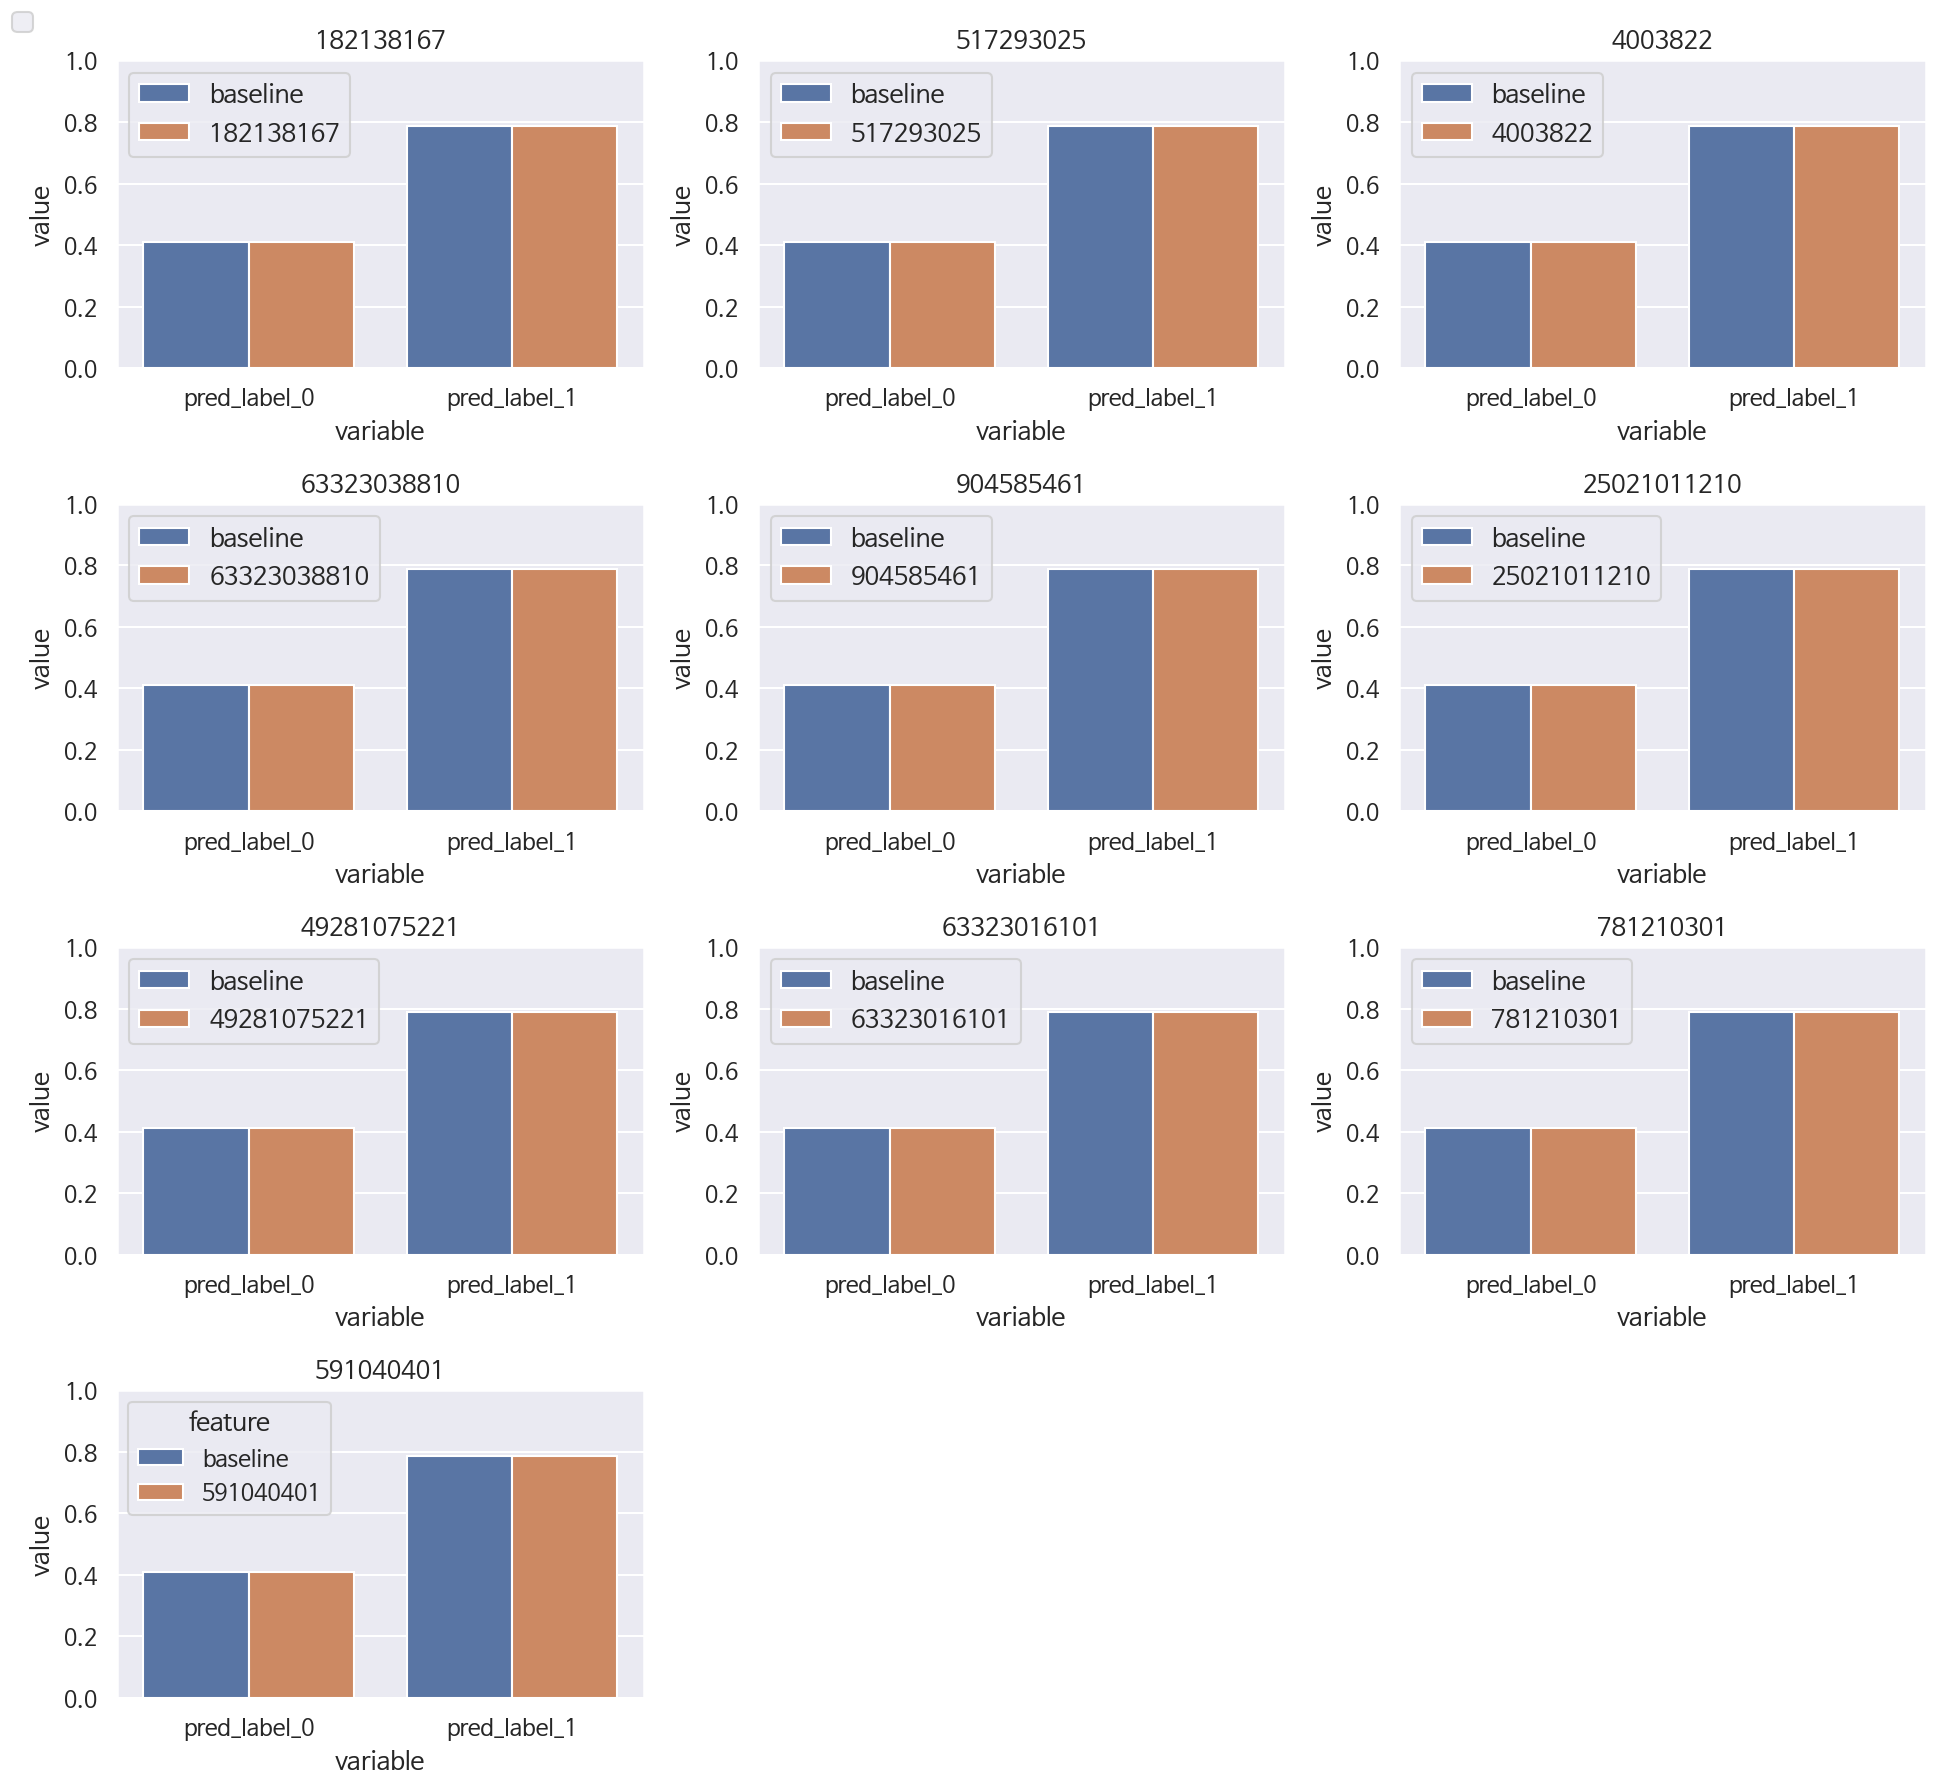

In [72]:
change(PRE_list,1,0)

## PRO - top10

10it [00:04,  2.32it/s]
No handles with labels found to put in legend.


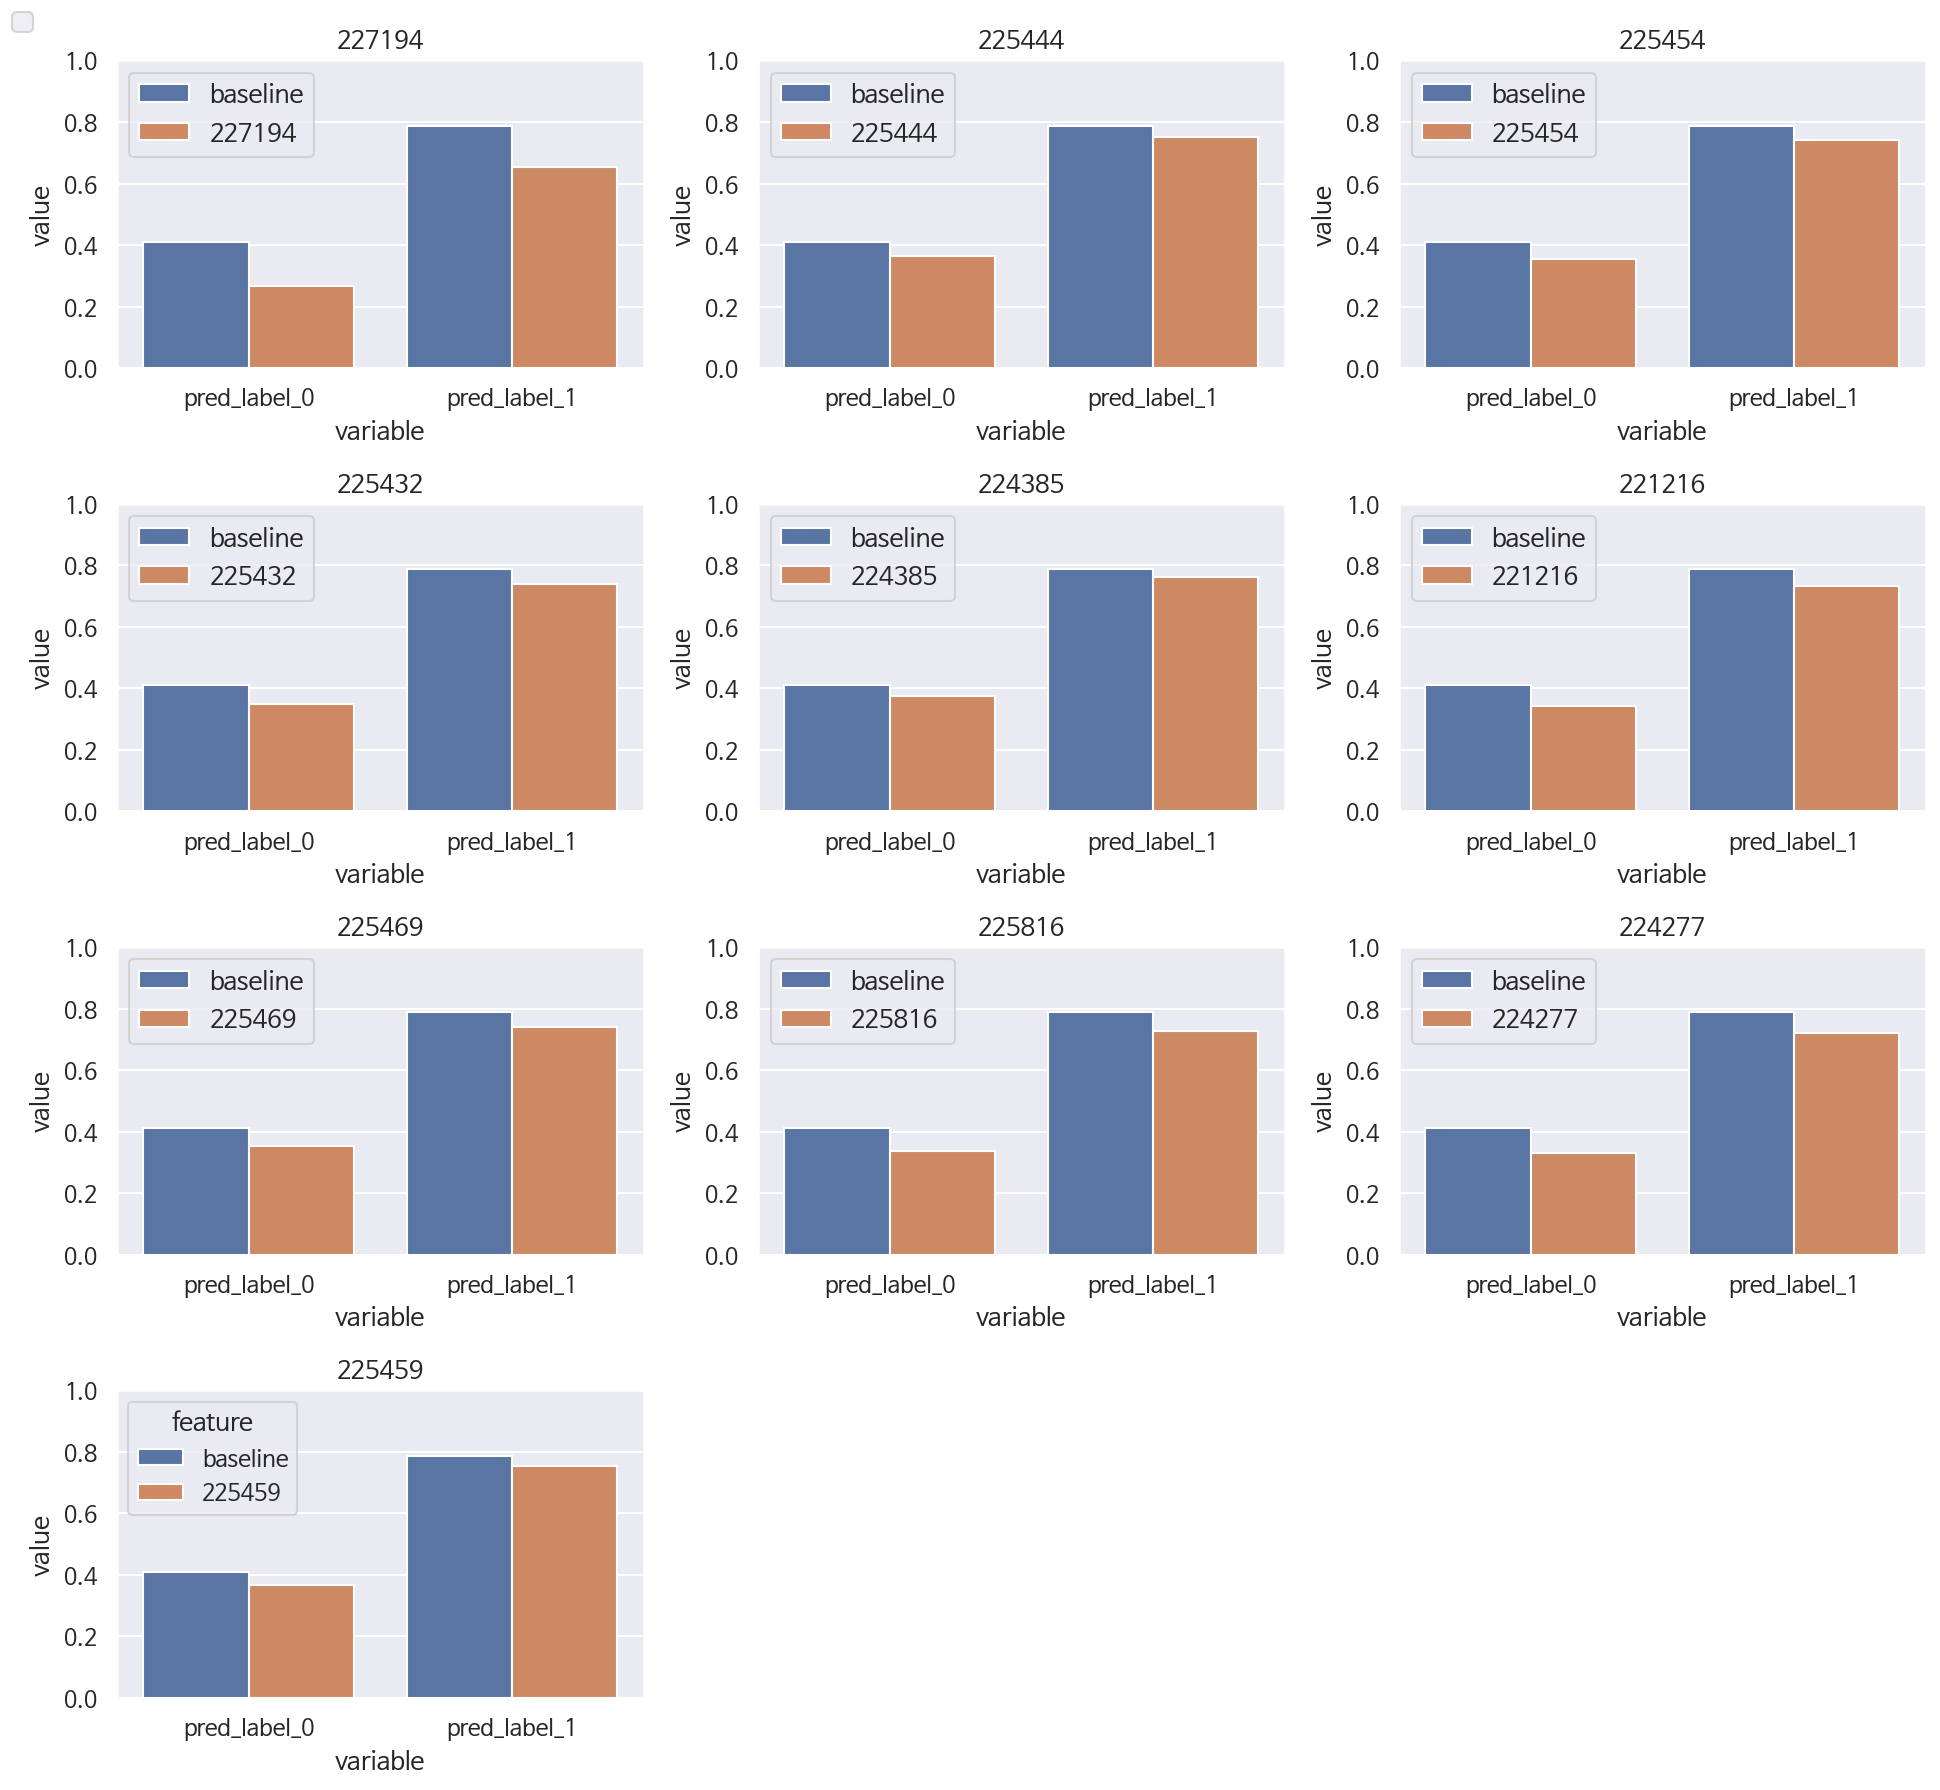

In [73]:
change(PRO_list,0,1)

10it [00:04,  2.35it/s]
No handles with labels found to put in legend.


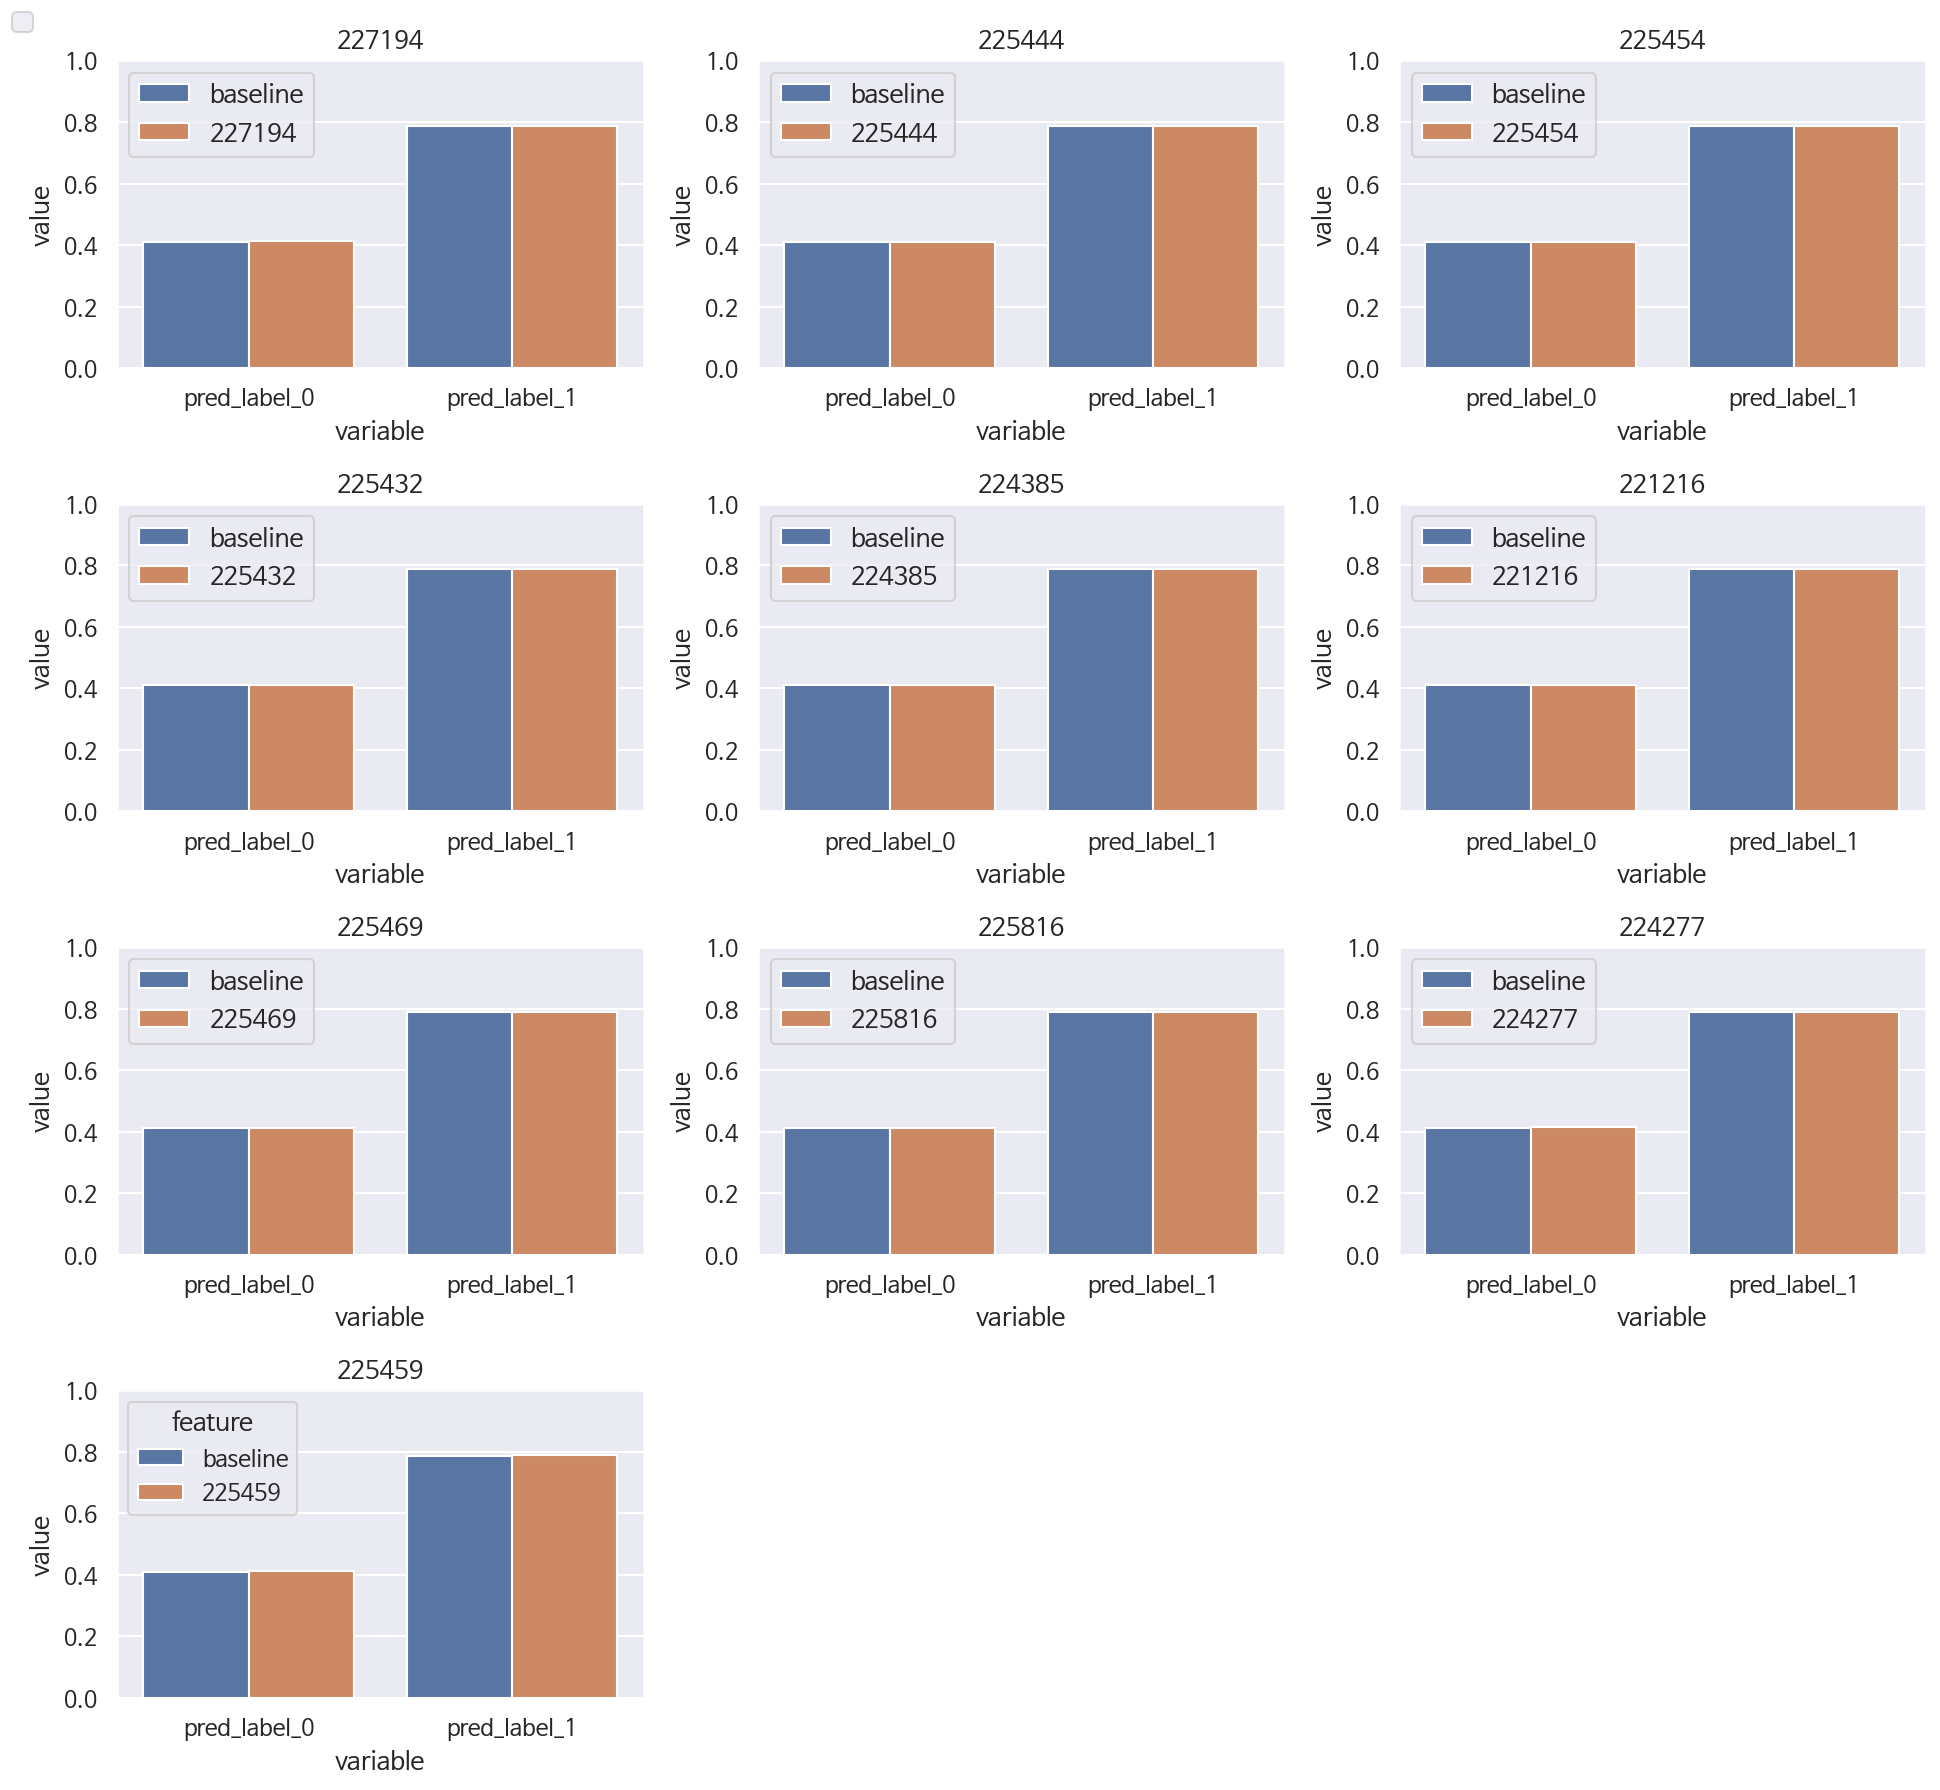

In [74]:
change(PRO_list,1,0)

## LAB - top10

10it [00:04,  2.36it/s]
No handles with labels found to put in legend.


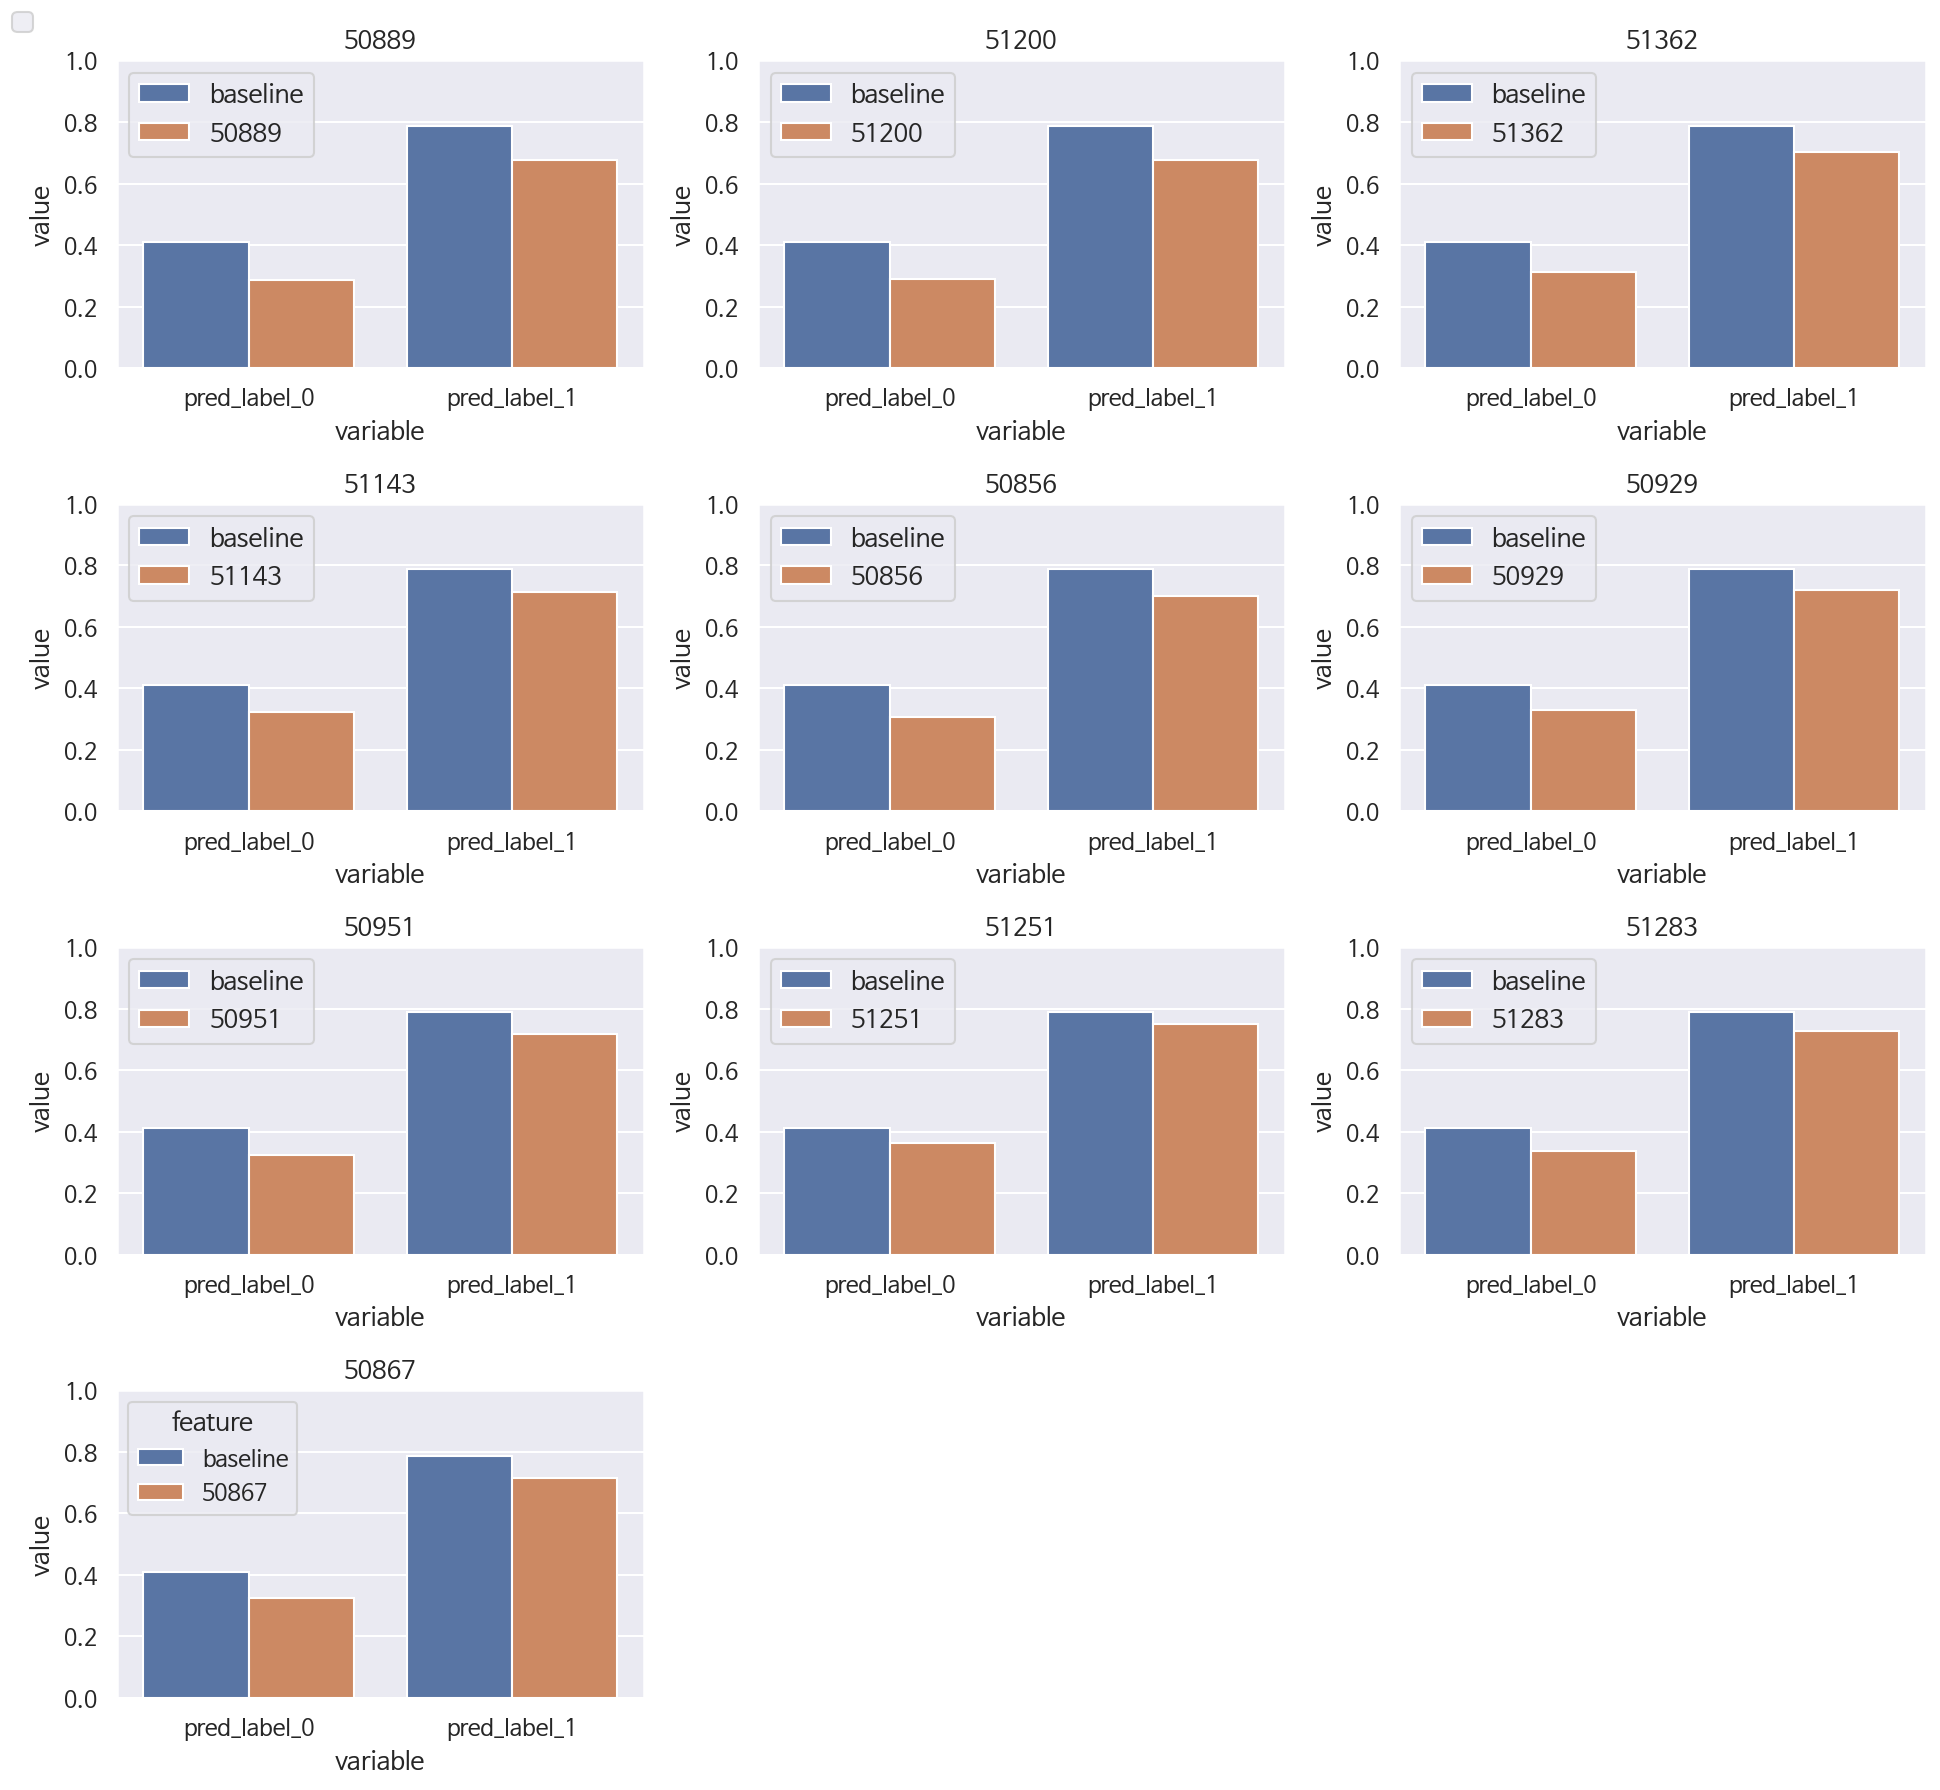

In [75]:
change(LAB_list,0,1)

10it [00:04,  2.34it/s]
No handles with labels found to put in legend.


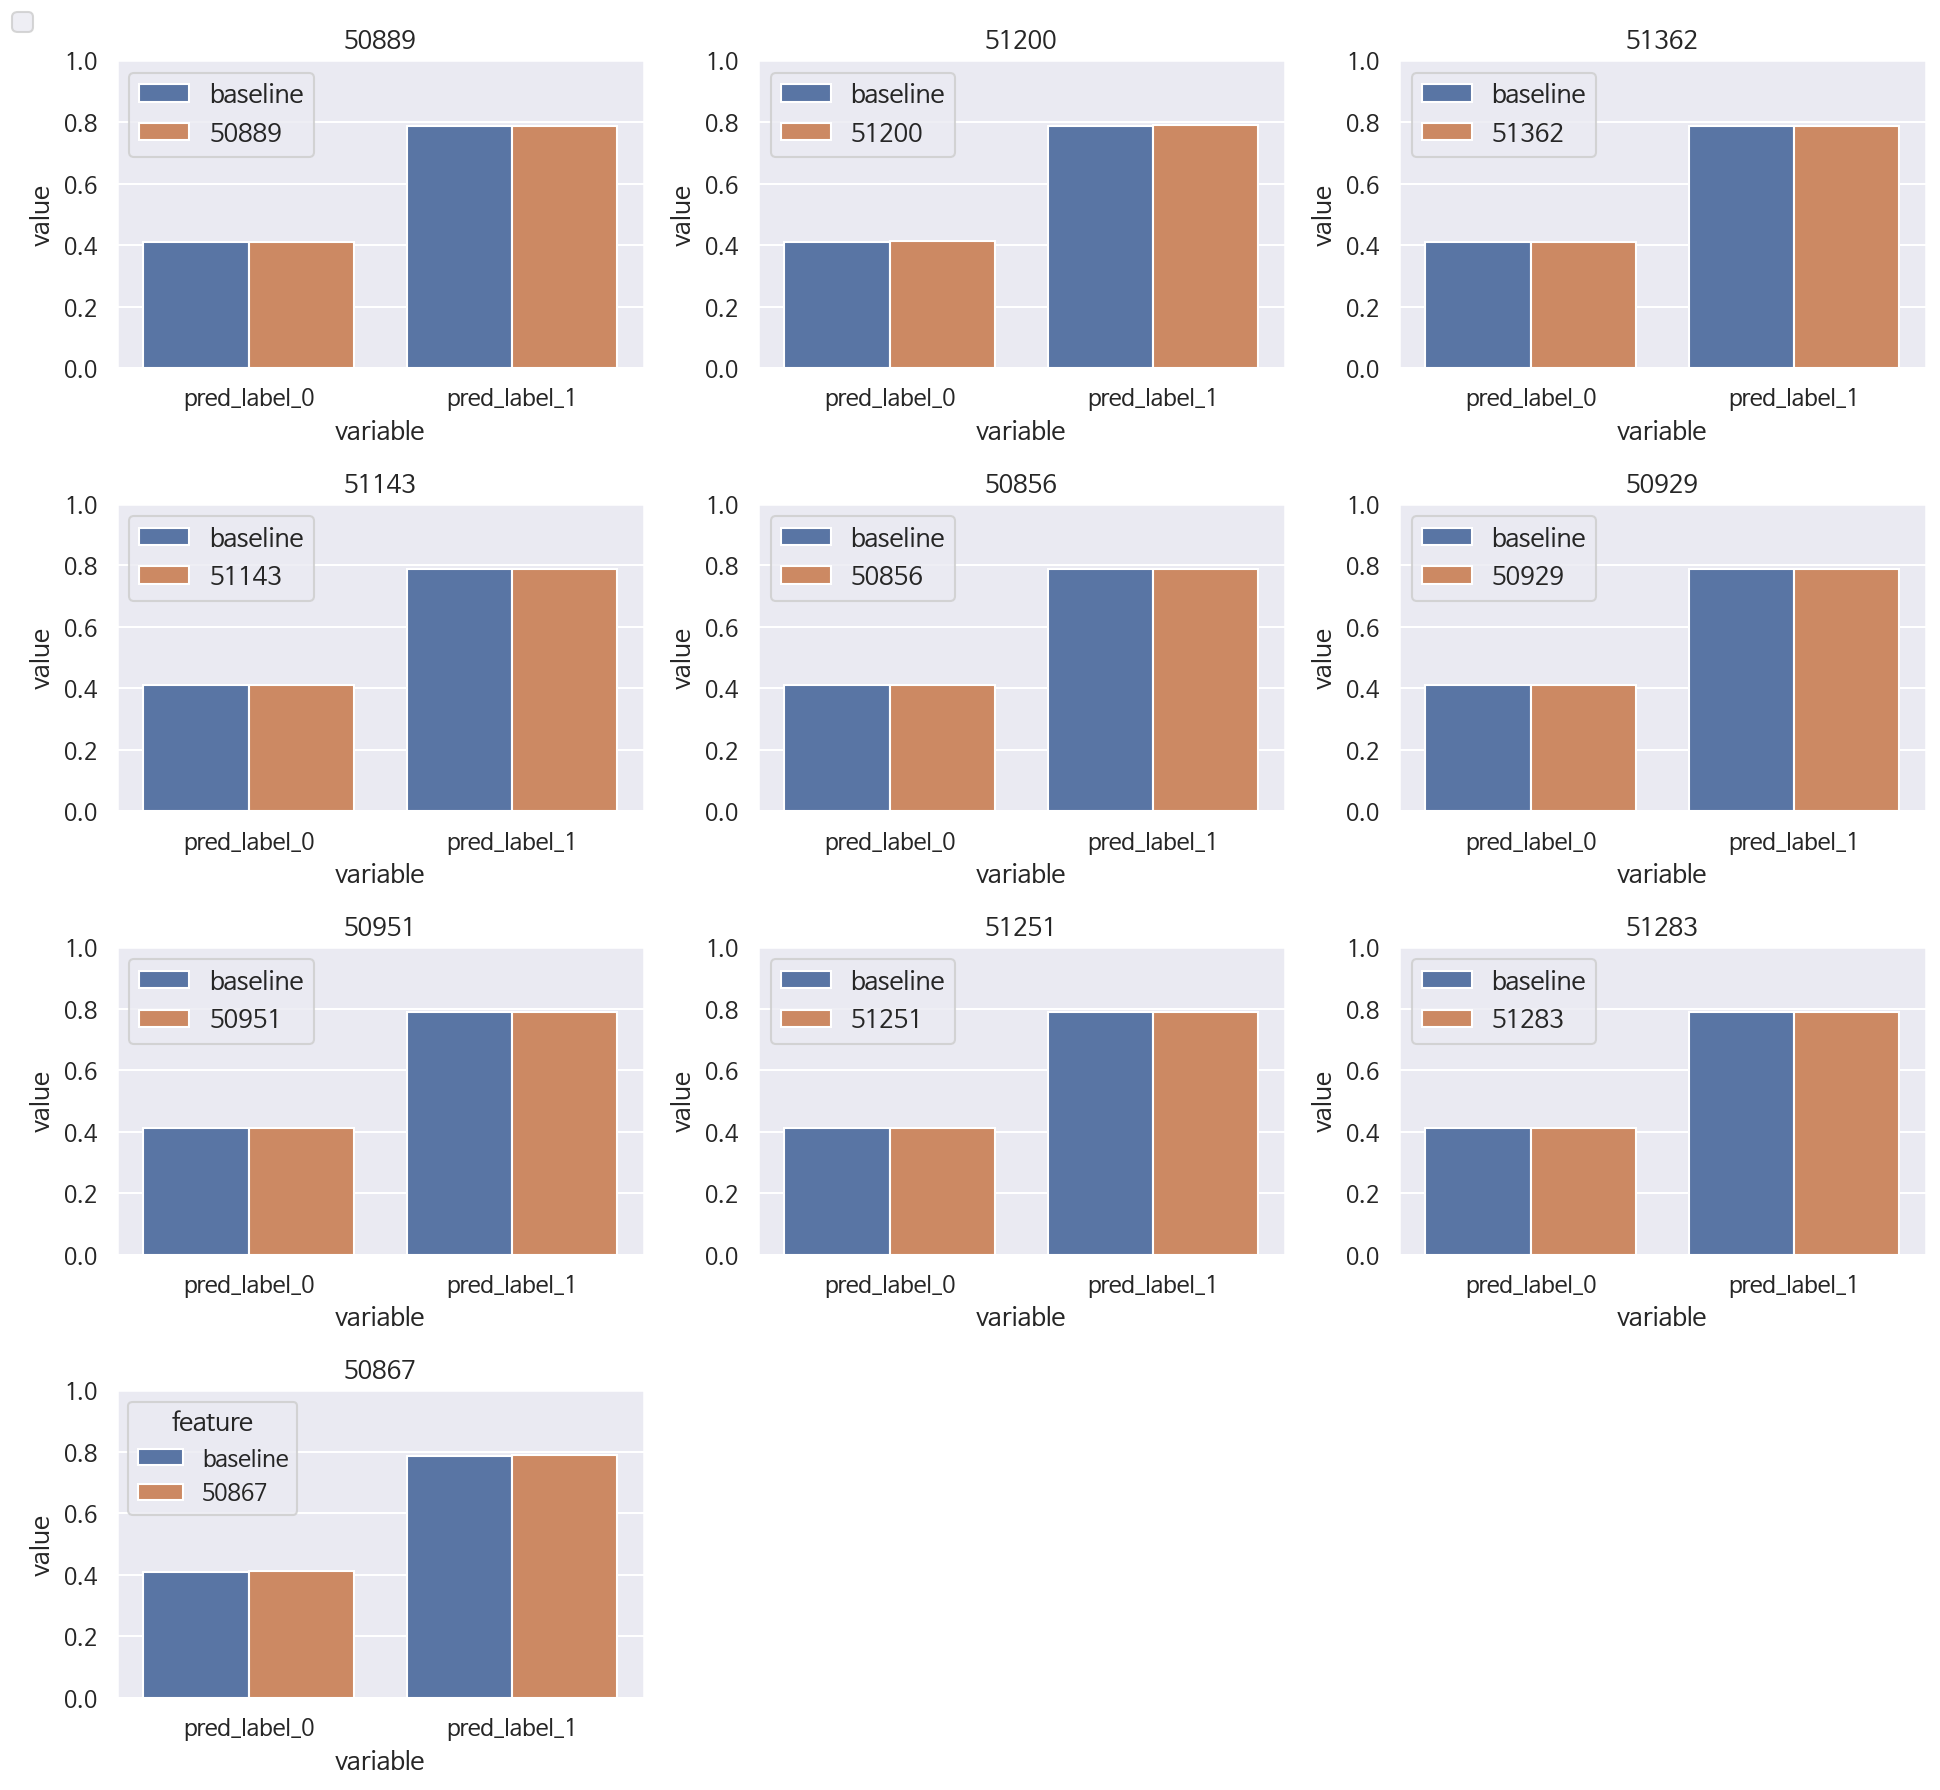

In [76]:
change(LAB_list,1,0)